**<font size = 4> <font color = 'cyan'> IMPORT MODULES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.api as sms
from scipy.stats import shapiro
import streamlit as st
import joblib
import pickle

**<font size = 4> <font color = 'cyan'> LOADING DATA**

In [2]:
# Set file path and convert csv file to pandas data frame
file_path = r'C:\Users\Sarvesh\Desktop\STAT 4355 Assignments\STAT 4355 Final Project\admission_data.csv'
grad_df = pd.read_csv(file_path)

**<font size = 4> <font color = 'cyan'> CLEANING DATA**

In [3]:
# Assign column names
grad_df.columns = ['GRE', 'TOEFL', 'UnivRtg', 'SOP', 'LOR', 'CGPA', 'Research', 'AdmitChance']
# Remove duplicates
grad_df = grad_df.drop_duplicates()
# Remove entries with missing values
grad_df = grad_df.dropna()
# Check variable data types
print(grad_df.info())

# Change scaling for AdmitChance
grad_df['AdmitChance'] = grad_df['AdmitChance'] * 100

print(grad_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GRE          500 non-null    int64  
 1   TOEFL        500 non-null    int64  
 2   UnivRtg      500 non-null    int64  
 3   SOP          500 non-null    float64
 4   LOR          500 non-null    float64
 5   CGPA         500 non-null    float64
 6   Research     500 non-null    int64  
 7   AdmitChance  500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB
None
     GRE  TOEFL  UnivRtg  SOP  LOR  CGPA  Research  AdmitChance
0    337    118        4  4.5  4.5  9.65         1         92.0
1    324    107        4  4.0  4.5  8.87         1         76.0
2    316    104        3  3.0  3.5  8.00         1         72.0
3    322    110        3  3.5  2.5  8.67         1         80.0
4    314    103        2  2.0  3.0  8.21         0         65.0
..   ...    ...      ...  ...  ...  

**<font size = 4> <font color = 'cyan'> EXPLORATORY DATA ANALYSIS (PLOTS) PT.1**

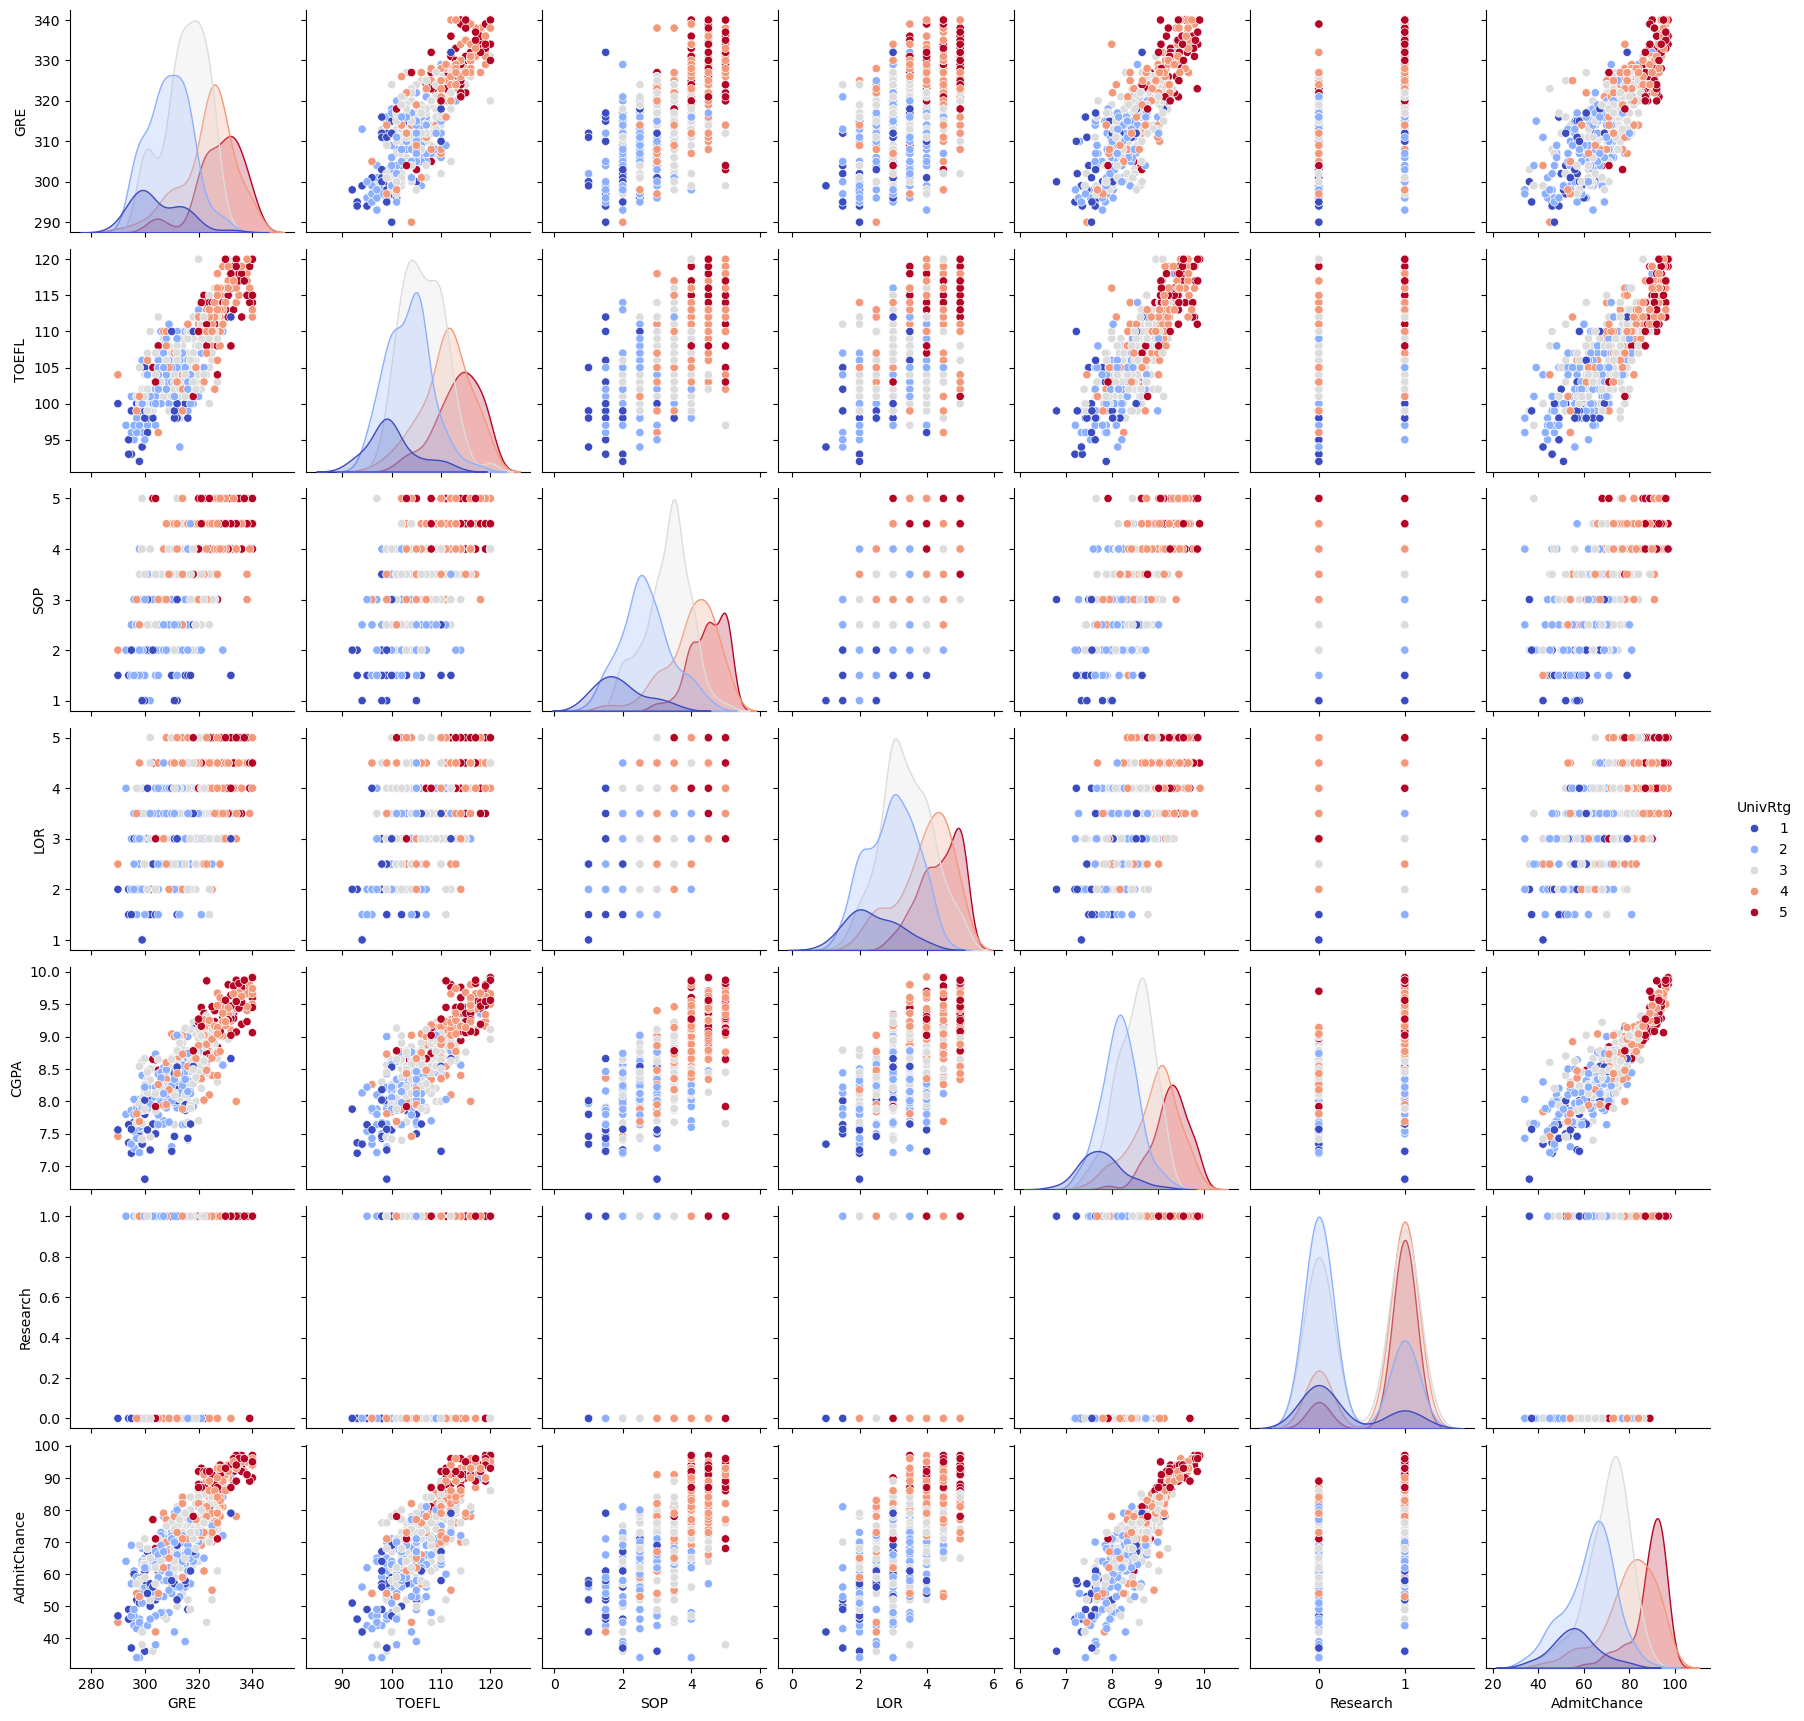

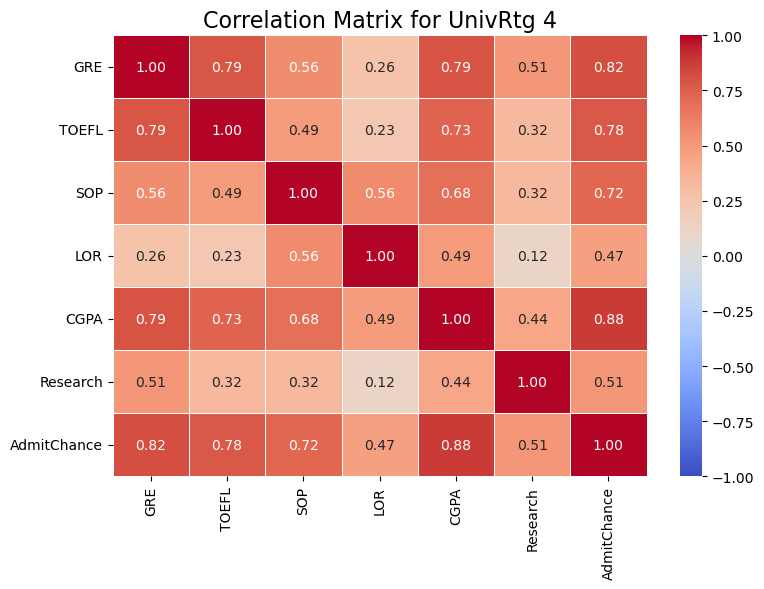

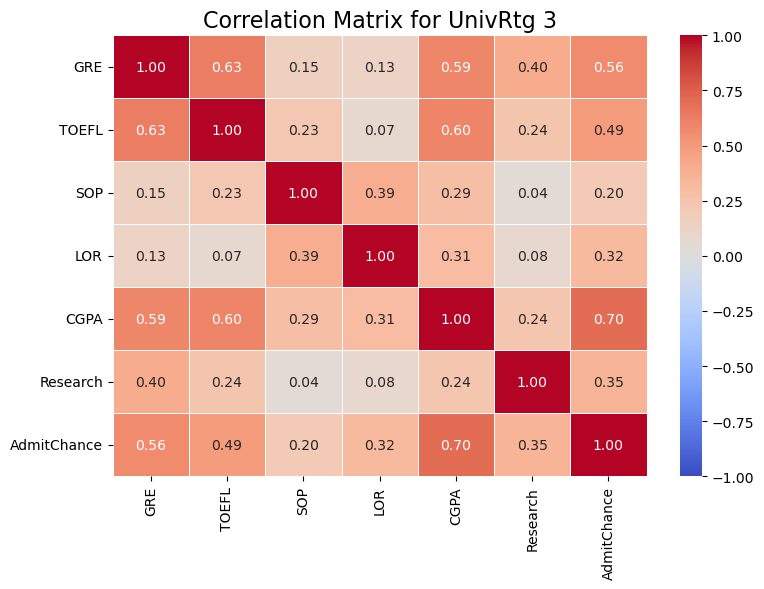

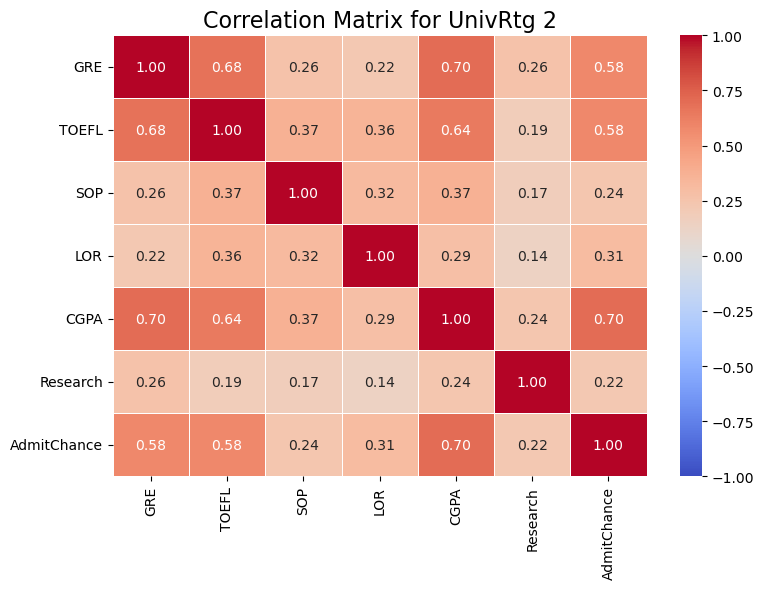

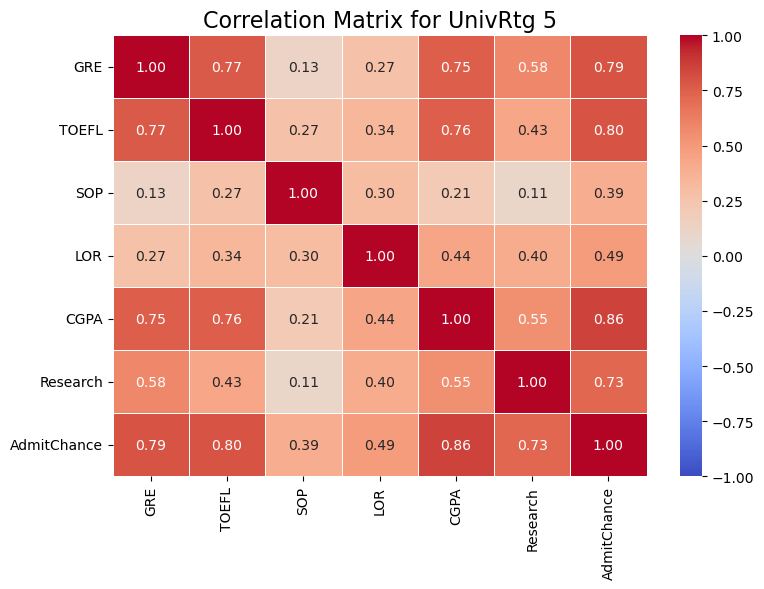

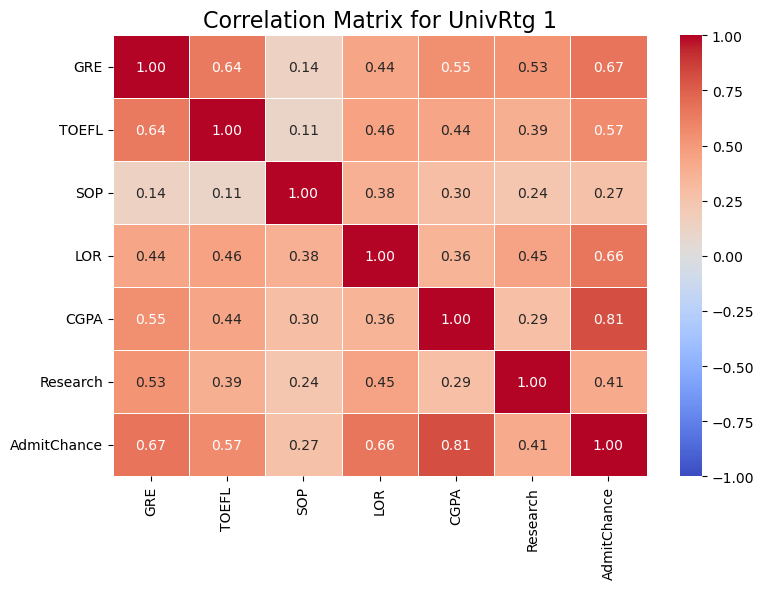

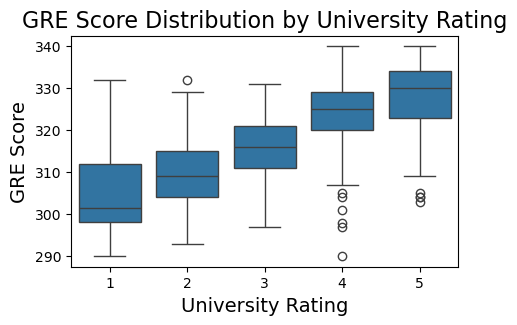

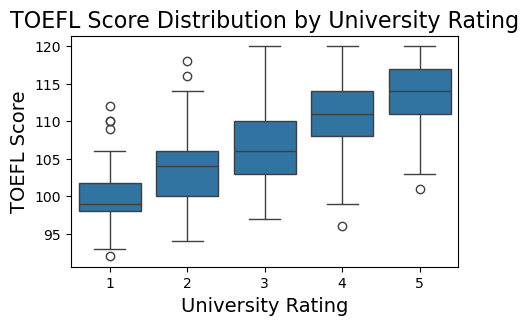

<Figure size 500x300 with 0 Axes>

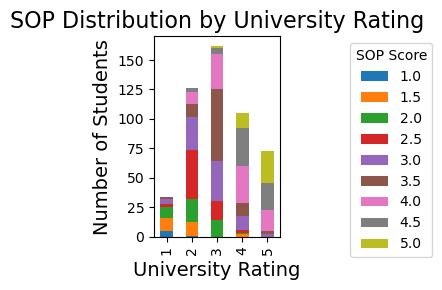

<Figure size 500x300 with 0 Axes>

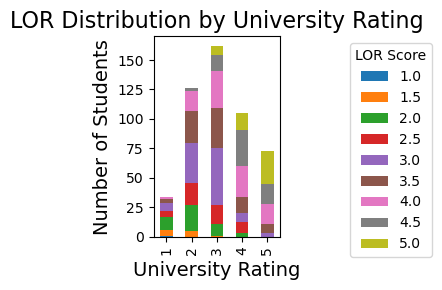

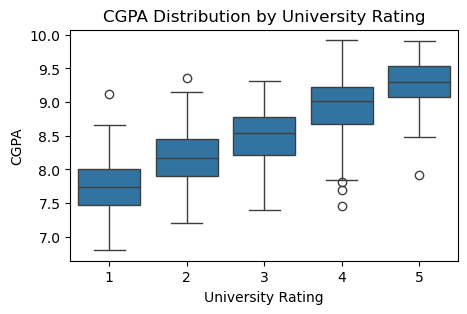

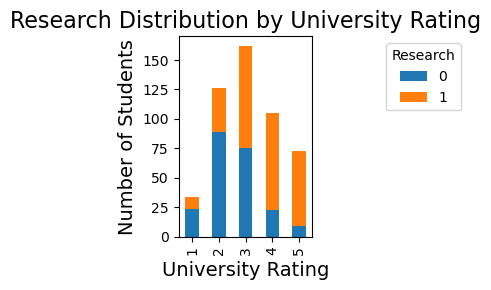

<Figure size 500x300 with 0 Axes>

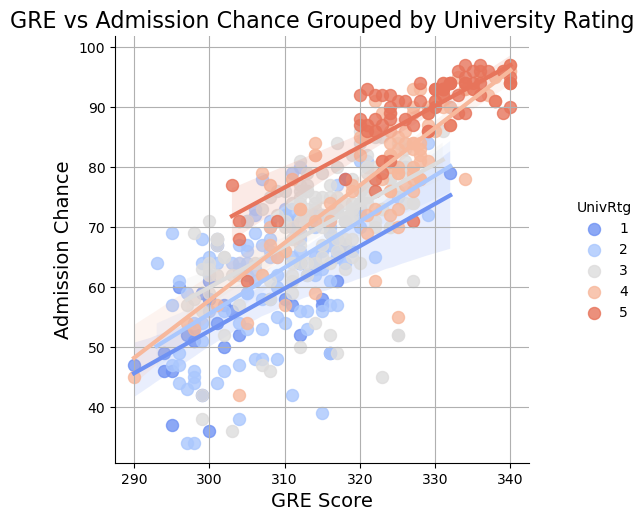

<Figure size 500x300 with 0 Axes>

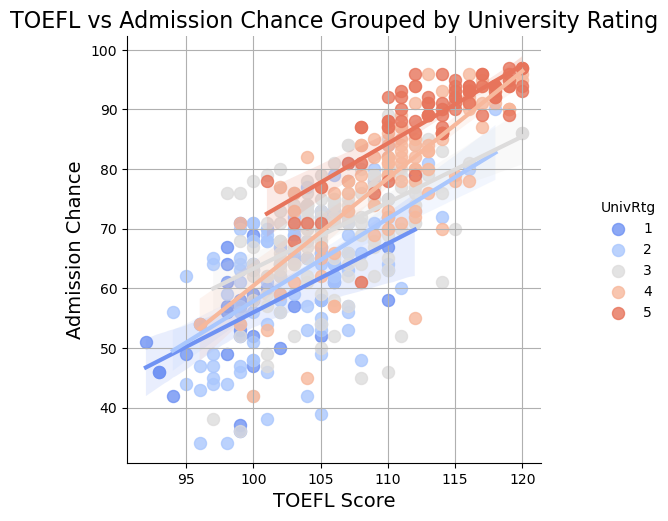

<Figure size 500x300 with 0 Axes>

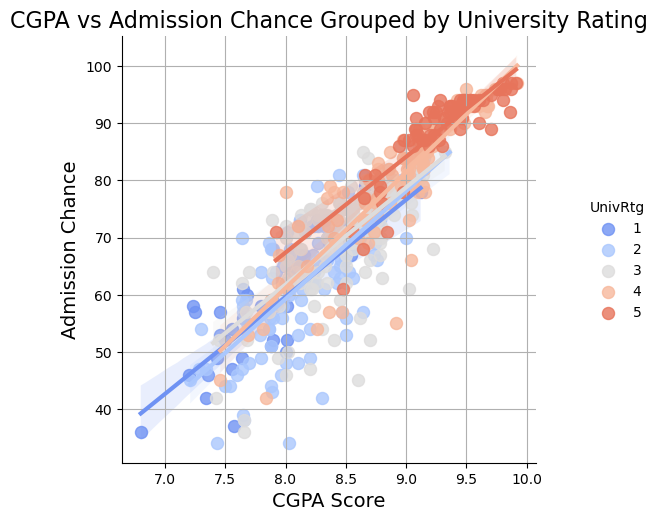

In [4]:
# Pair Plots by University Rating
sns.pairplot(data=grad_df, hue="UnivRtg", diag_kind="kde", palette="coolwarm")
plt.show()

# Correlation Matrices by University Ratings
for rating in grad_df['UnivRtg'].unique():
    subset = grad_df[grad_df['UnivRtg'] == rating]
    corr_data = subset[['GRE', 'TOEFL', 'SOP', 'LOR', 'CGPA', 'Research', 
                        'AdmitChance']]
    corr_matrix = corr_data.corr()

    plt.figure(figsize = (8, 6))
    sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = '.2f', 
                linewidths = 0.5, vmin = -1, vmax = 1)
    plt.title(f'Correlation Matrix for UnivRtg {rating}', fontsize = 16)
    plt.tight_layout()
    plt.show()

# Box Plot: University Rating vs GRE
plt.figure(figsize = (5, 3))
sns.boxplot(y = 'GRE', x = 'UnivRtg', data = grad_df)
plt.title('GRE Score Distribution by University Rating', fontsize = 16)
plt.xlabel('University Rating', fontsize = 14)
plt.ylabel('GRE Score', fontsize = 14)
plt.show()

# Box Plot: University Rating vs TOEFL
plt.figure(figsize = (5, 3))
sns.boxplot(y = 'TOEFL', x = 'UnivRtg', data = grad_df)
plt.title('TOEFL Score Distribution by University Rating', fontsize = 16)
plt.xlabel('University Rating', fontsize = 14)
plt.ylabel('TOEFL Score', fontsize = 14)
plt.show()

# Bar Plot: University Rating vs SOP 
plt.figure(figsize = (5, 3))
sop_counts = grad_df.groupby(['UnivRtg', 'SOP']).size().unstack()
sop_counts.plot(kind = 'bar', stacked = True, figsize = (5, 3))

plt.title('SOP Distribution by University Rating', fontsize = 16)
plt.xlabel('University Rating', fontsize = 14)
plt.ylabel('Number of Students', fontsize = 14)
plt.legend(title ='SOP Score', bbox_to_anchor =(1.5, 1), loc= 'upper left')
plt.tight_layout()
plt.show()

# Bar Plot: University Rating vs LOR
plt.figure(figsize = (5, 3))
lor_counts = grad_df.groupby(['UnivRtg', 'LOR'], observed = False).size().unstack()
lor_counts.plot(kind = 'bar', stacked = True, figsize = (5, 3))

plt.title('LOR Distribution by University Rating', fontsize = 16)
plt.xlabel('University Rating', fontsize = 14)
plt.ylabel('Number of Students', fontsize = 14)
plt.legend(title = 'LOR Score', bbox_to_anchor = (1.5, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

# Box Plot: University Rating vs CGPA
plt.figure(figsize = (5, 3))
sns.boxplot(y = 'CGPA', x = 'UnivRtg', data = grad_df)
plt.title('CGPA Distribution by University Rating')
plt.xlabel('University Rating')
plt.ylabel('CGPA')
plt.show()

# Bar Plot: University Rating vs Research
res_counts = grad_df.groupby(['UnivRtg', 'Research'], observed = False).size().unstack()
res_counts.plot(kind = 'bar', stacked = True, figsize = (5, 3))

plt.title('Research Distribution by University Rating', fontsize = 16)
plt.xlabel('University Rating', fontsize = 14)
plt.ylabel('Number of Students', fontsize = 14)
plt.legend(title = 'Research', bbox_to_anchor = (1.5, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

# Scatter Plot: GRE vs AdmitChance (grouped by University Rating)
grad_df['UnivRtg'] = grad_df['UnivRtg'].astype('category')

plt.figure(figsize = (5, 3))
sns.lmplot(data = grad_df, x = 'GRE', y = 'AdmitChance', hue = 'UnivRtg', scatter_kws = {'s':75}, palette = 'coolwarm', 
          line_kws = {'linewidth' : 3})
plt.title('GRE vs Admission Chance Grouped by University Rating', fontsize = 16)
plt.xlabel('GRE Score', fontsize = 14)
plt.ylabel('Admission Chance', fontsize = 14)
plt.grid(True)
plt.show()

# Scatter Plot: TOEFL vs AdmitChance (grouped by University Rating)
plt.figure(figsize = (5, 3))
sns.lmplot(data = grad_df, x = 'TOEFL', y = 'AdmitChance', hue = 'UnivRtg', scatter_kws = {'s':75}, palette = 'coolwarm', 
          line_kws = {'linewidth' : 3})
plt.title('TOEFL vs Admission Chance Grouped by University Rating', fontsize = 16)
plt.xlabel('TOEFL Score', fontsize = 14)
plt.ylabel('Admission Chance', fontsize = 14)
plt.grid(True)
plt.show()

# Scatter Plot: CGPA vs AdmitChance (grouped by University Rating)
plt.figure(figsize = (5, 3))
sns.lmplot(data = grad_df, x = 'CGPA', y = 'AdmitChance', hue = 'UnivRtg', scatter_kws = {'s':75}, palette = 'coolwarm', 
          line_kws = {'linewidth' : 3})
plt.title('CGPA vs Admission Chance Grouped by University Rating', fontsize = 16)
plt.xlabel('CGPA Score', fontsize = 14)
plt.ylabel('Admission Chance', fontsize = 14)
plt.grid(True)
plt.show()

**<font size = 4> <font color = 'cyan'> EXPLORATORY DATA ANALYSIS (STATISTICAL TESTS) PT.2**

In [5]:
# ANOVA Test for Admission Chance based on University Rating
# Perform ANOVA
anova_result = stats.f_oneway(
    grad_df[grad_df['UnivRtg'] == 1]['AdmitChance'],
    grad_df[grad_df['UnivRtg'] == 2]['AdmitChance'],
    grad_df[grad_df['UnivRtg'] == 3]['AdmitChance'],
    grad_df[grad_df['UnivRtg'] == 4]['AdmitChance'],
    grad_df[grad_df['UnivRtg'] == 5]['AdmitChance']
)

# Output the result of the ANOVA
print(f'ANOVA Test Statistic: {anova_result.statistic}')
print(f'ANOVA p-value: {anova_result.pvalue}')

# Post-Hoc Analysis
tukey_result = pairwise_tukeyhsd(endog = grad_df['AdmitChance'], groups = grad_df['UnivRtg'], alpha = 0.05)
print(tukey_result)

# Initial Confidence Intervals for Admission Chance based on University Rating
grouped = grad_df.groupby('UnivRtg', observed = False)['AdmitChance']
confidence_intervals = grouped.apply(lambda x: sms.DescrStatsW(x).tconfint_mean())
confidence_intervals_df = pd.DataFrame(confidence_intervals.tolist(), columns=['Lower CI', 'Upper CI'], index=confidence_intervals.index)
confidence_intervals_df.reset_index(inplace=True)
print(confidence_intervals_df)

ANOVA Test Statistic: 114.0080434140001
ANOVA p-value: 7.753395328022908e-69
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   6.4052 0.0111  0.9958 11.8146   True
     1      3  14.0842    0.0  8.8041 19.3644   True
     1      4   23.956    0.0 18.4329 29.4792   True
     1      5  32.6023    0.0 26.7906 38.4141   True
     2      3    7.679    0.0  4.3542 11.0038   True
     2      4  17.5508    0.0 13.8522 21.2494   True
     2      5  26.1971    0.0   22.08 30.3142   True
     3      4   9.8718    0.0  6.3649 13.3786   True
     3      5  18.5181    0.0 14.5723 22.4639   True
     4      5   8.6463    0.0  4.3808 12.9118   True
----------------------------------------------------
  UnivRtg   Lower CI   Upper CI
0       1  52.736036  59.675729
1       2  60.709402  64.512820
2       3  68.762979  71.817268
3       4  77.891338  82.432471
4       5  87.064981 

**<font size = 4> <font color = 'cyan'> COMMON FUNCTIONS USED FOR MODEL BUILDING**

In [7]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bd = Q1 - 1.25 * IQR
    upper_bd = Q3 + 1.25 * IQR
    
    filtered_df = df[(df >= lower_bd) & (df <= upper_bd)]

    filtered_df = filtered_df.dropna()

    return filtered_df

def build_display_lm(x_df, y_df):
    # Build and Display Model
    x_df = sm.add_constant(x_df)
    model_df = sm.OLS(y_df, x_df).fit()
    print(model_df.summary())

    total_y = len(y_df)

    # Calculate Residuals for Analysis
    residuals = model_df.resid
    R_stud_resid = model_df.get_influence().resid_studentized_external
    stud_resid = model_df.get_influence().resid_studentized_internal
    std_resid = residuals / np.std(residuals)
    fitted = model_df.fittedvalues

    # resid = {'org_resid': residuals, 'RStud_resid' : R_stud_resid, 
              #'Stud_resid' : stud_resid, 'Std_resid' : std_resid}
    
    # Build Residual Plot
    plt.figure(figsize = (8, 6))
    sns.residplot(x = fitted, y = residuals, line_kws = {'color' : 'red', 'lw' : 2})
    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 1)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

    # Build R-Student Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(R_stud_resid) + 1), R_stud_resid)
    plt.title('R-Student Residuals')
    plt.xlabel('Index')
    plt.ylabel('R-Student Residual')
    plt.ylim(-4, 4)
    
    plt.axhline(y=3, color='red', linewidth=2, linestyle='--')
    plt.axhline(y=-3, color='red', linewidth=2, linestyle='--')
    plt.show()
    
    R_stud_out = np.where((R_stud_resid >= 3) | (R_stud_resid <= -3))[0]
    print(R_stud_out)

    # Build Studentized Residuals Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(stud_resid) + 1), stud_resid)
    plt.title('Studentized Residuals')
    plt.xlabel('Index')
    plt.ylabel('Studentized Residual')
    plt.ylim(-4, 4)
    
    plt.axhline(y=3, color='red', linewidth=2, linestyle='--')
    plt.axhline(y=-3, color='red', linewidth=2, linestyle='--')
    plt.show()
    
    stud_out = np.where((stud_resid >= 3.0) | (stud_resid <= -3.0))[0]
    print(stud_out)

    # Build QQ-Plot
    sm.qqplot(residuals, line = '45', fit = True)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

    # Build Histogram of Residuals
    plt.figure(figsize = (8, 6))
    sns.histplot(residuals, kde = True, bins = math.ceil(math.log2(total_y) + 1), color = 'blue')
    plt.axvline(0, color = 'black', linestyle = '--', linewidth = 1)
    plt.xlabel('Residuals')
    plt.ylabel('Frequeny')
    plt.title('Histogram of Residuals')
    plt.show()

    return residuals
    
def calculate_vifs(df):
    df = sm.add_constant(df)
    vif_df = pd.DataFrame()
    vif_df['Feature'] = df.columns
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif_df)

def test_model(x_df, y_df, folds):
    k = folds  # You can adjust this number as needed
    kf = KFold(n_splits=k, shuffle=True, random_state = 34)

    mse_list = []  # List to store MSE values for each fold
    r2_list = []  # List to store R² values for each fold
    rmse_list = []  # List to store RMSE values for each fold

    # K-fold Cross Validation
    for train_index, test_index in kf.split(x_df):
        # Split the data into training and testing sets for the current fold
        x_train_fold, x_test_fold = x_df.iloc[train_index], x_df.iloc[test_index]
        y_train_fold, y_test_fold = y_df.iloc[train_index], y_df.iloc[test_index]
    
        # Fit the model on the training data
        model_grad_df_split = sm.OLS(y_train_fold, sm.add_constant(x_train_fold)).fit()
    
        # Make predictions on the test data
        y_pred_fold = model_grad_df_split.predict(sm.add_constant(x_test_fold))
    
        # Calculate MSE, RMSE, and R² for the current fold
        mse = mean_squared_error(y_test_fold, y_pred_fold)
        rmse = math.sqrt(mse)
        r2 = r2_score(y_test_fold, y_pred_fold)
    
        # Store the results for this fold
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)

    # Calculate the average performance metrics across all folds
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)
    
    # Print the cross-validation results
    print(f"Average Mean Squared Error (MSE): {avg_mse}")
    print(f"Average Root Mean Squared Error (RMSE): {avg_rmse}")
    print(f"Average R-squared (R²): {avg_r2}")
    
    # Optionally, you can print the actual vs. predicted values from the last fold
    act_vs_pred_grad_df = pd.DataFrame({
        'Actual': y_test_fold.values,  # Ensure we use values, not the index
        'Predicted': y_pred_fold
    })
    
    print(act_vs_pred_grad_df)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [1.0],
    'gamma': [0, 0,1],
    'lambda': [0, 0.5, 1],
    'alpha': [0, 0.5, 1]
}

# Function for running the XGBoost model
def run_XGBoost(param_grid, folds, x_df, y_df):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=34)

    # Hyperparameter Tuning with GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb.XGBRegressor(objective='reg:squarederror'),
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=folds,
        verbose=1
    )

    # Fit GridSearchCV on the training data
    grid_search.fit(x_train, y_train)

    # Best Parameters
    print(f"Best Parameters: {grid_search.best_params_}")

    # Get the best model from grid search
    best_xgb_model = grid_search.best_estimator_

    # Test the best model on the unseen test set
    xgb_hyp_pred = best_xgb_model.predict(x_test)

    # Calculate metrics on the test set
    mse = mean_squared_error(y_test, xgb_hyp_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, xgb_hyp_pred)
    print(f"Test Set Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-sqd : {r2}")
    print(f"RMSE : {rmse}")

    # Create a DataFrame to compare actual vs. predicted values
    xgb_hyp_act_vs_pred = pd.DataFrame({
        'Actual': y_test, 
        'XGB_HYP_PRED': xgb_hyp_pred
    })

    print(xgb_hyp_act_vs_pred)

    return best_xgb_model

**<font size = 4> <font color = 'cyan'> MODEL BUILDING & TESTING (NO UNIV RTG  & NO NO MODIFICATIONS) PT.1**

                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     376.9
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          1.37e-180
Time:                        12:48:24   Log-Likelihood:                -1602.4
No. Observations:                 500   AIC:                             3219.
Df Residuals:                     493   BIC:                             3248.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -131.3127     10.166    -12.917      0.0

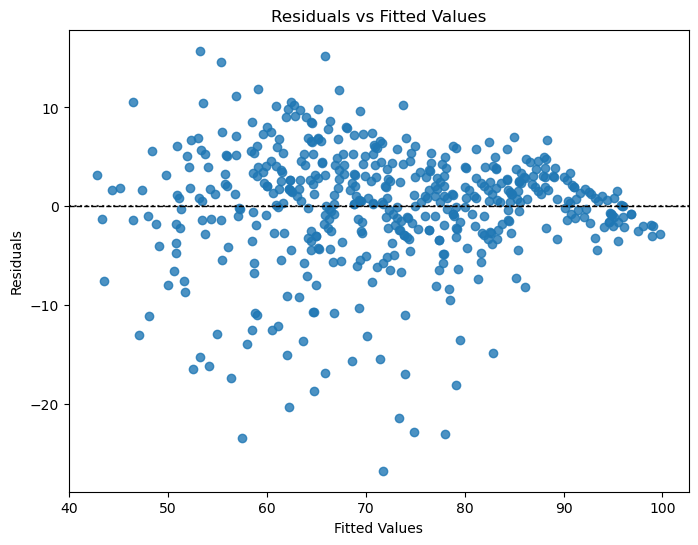

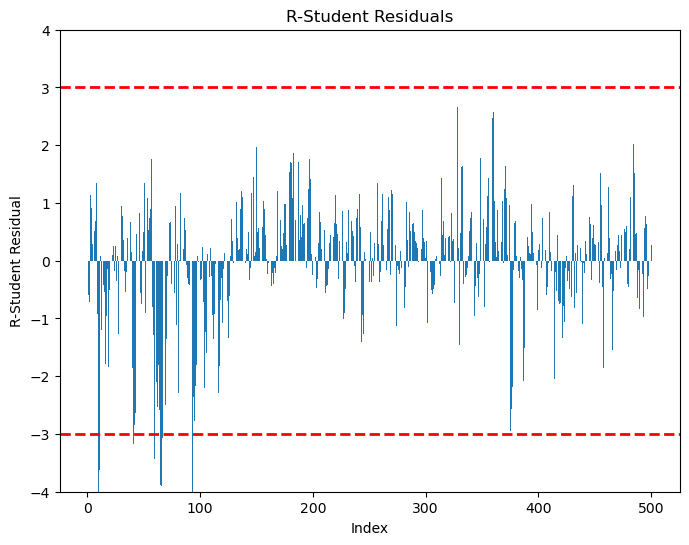

[ 9 10 40 59 64 65 66 92]


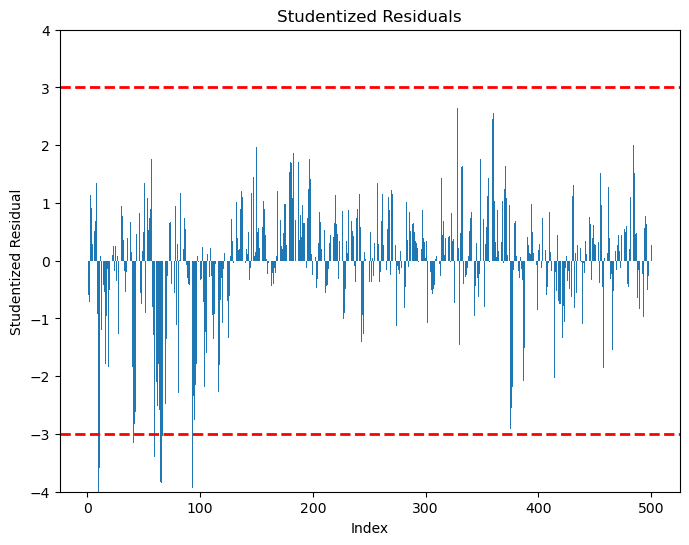

[ 9 10 40 59 64 65 66 92]


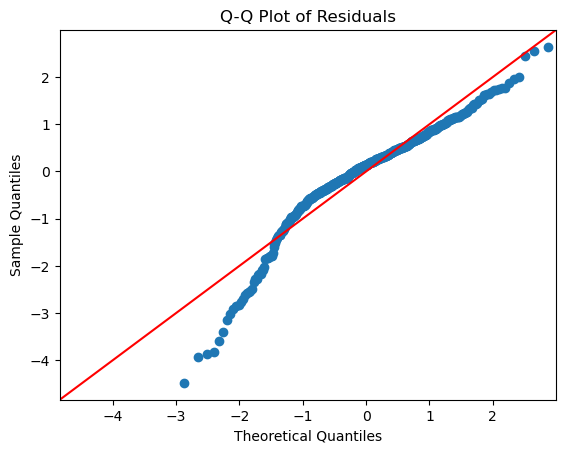

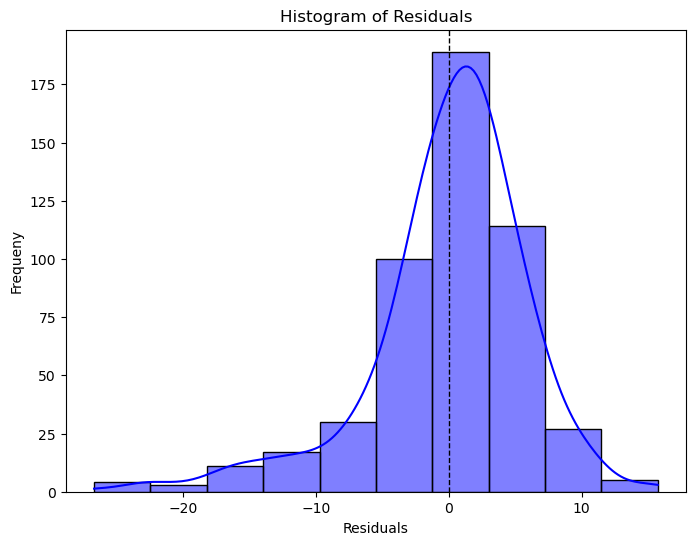

    Feature          VIF
0     const  1431.901340
1       GRE     4.453552
2     TOEFL     3.874175
3       SOP     2.451053
4       LOR     1.992803
5      CGPA     4.680725
6  Research     1.489430
Average Mean Squared Error (MSE): 36.351912090569215
Average Root Mean Squared Error (RMSE): 5.98312702798502
Average R-squared (R²): 0.8127452217623115
     Actual  Predicted
0      92.0  95.251887
1      76.0  80.026732
5      90.0  86.659607
13     62.0  64.679239
18     63.0  73.844398
..      ...        ...
457    37.0  48.142304
464    45.0  46.527469
469    86.0  84.208689
490    67.0  66.893104
496    96.0  98.666470

[100 rows x 2 columns]
Shapiro-Wilk Test Statistic: 0.9265434040903294
Shapiro-Wilk Test P-Value: 6.308499136481798e-15
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Test Set Metrics:
Mean Squar

In [8]:
# Initial Model without Normality/Linearity (Linear Regression)
x_grad_df_no_ur = grad_df[['GRE', 'TOEFL', 'SOP', 'LOR', 'CGPA', 'Research']]
y_grad_df_no_ur = grad_df['AdmitChance']

initial_resid = build_display_lm(x_grad_df_no_ur, y_grad_df_no_ur)
calculate_vifs(x_grad_df_no_ur)
test_model(x_grad_df_no_ur, y_grad_df_no_ur, 5)

# Shapiro-Wilk Test for Normality
stat, p_val = shapiro(initial_resid)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'Shapiro-Wilk Test P-Value: {p_val}')

# Initial Model (XGBoost)
xgb_no_ur = run_XGBoost(param_grid, 5, x_grad_df_no_ur, y_grad_df_no_ur)

**<font size = 4> <font color = 'cyan'> MODEL BUILDING & TESTING (NO UNIV RTG  & RESID FILTERING) PT.2**

                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     349.9
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          1.04e-171
Time:                        12:53:35   Log-Likelihood:                -1558.6
No. Observations:                 487   AIC:                             3131.
Df Residuals:                     480   BIC:                             3161.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -127.1509     10.310    -12.333      0.0

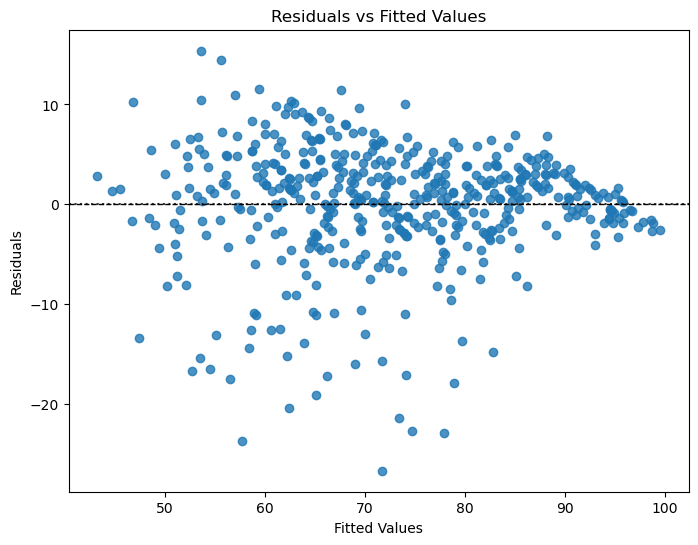

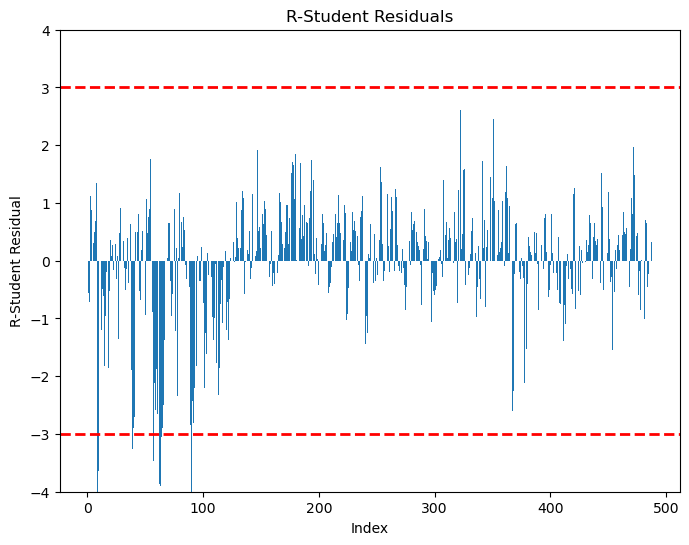

[ 8  9 38 56 61 62 63 89]


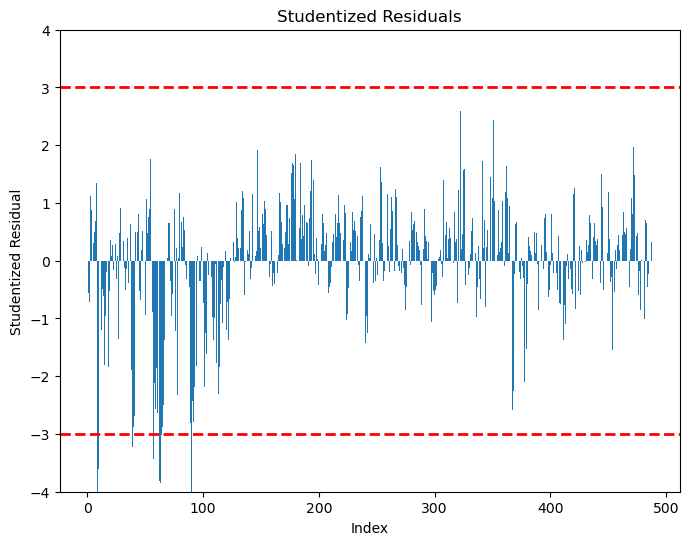

[ 8  9 38 56 61 62 63 89]


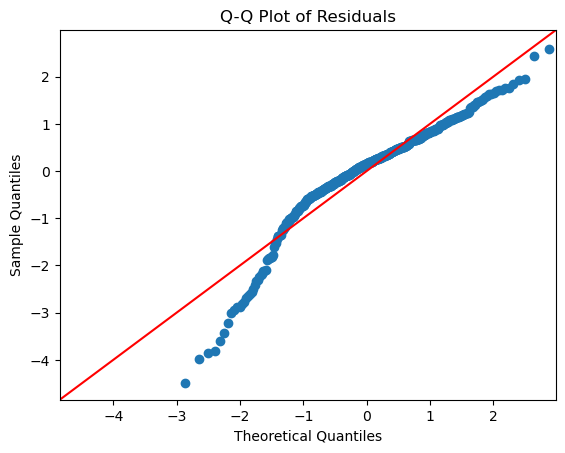

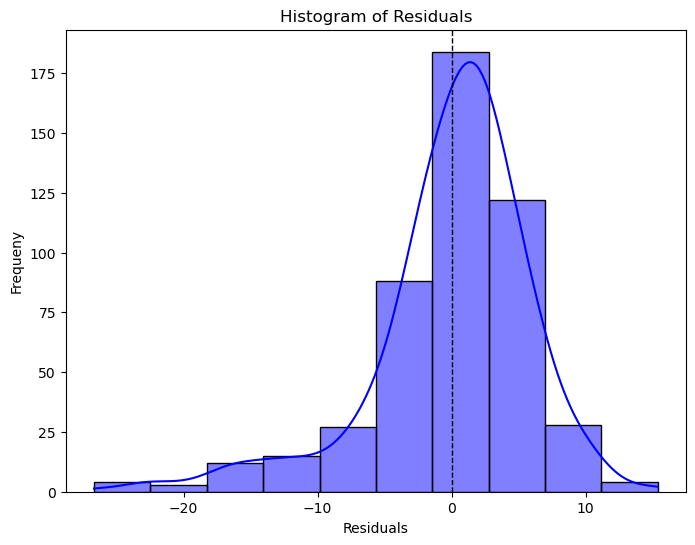

    Feature          VIF
0     const  1446.560771
1       GRE     4.362217
2     TOEFL     3.838133
3       SOP     2.407436
4       LOR     1.925528
5      CGPA     4.676773
6  Research     1.494645
Average Mean Squared Error (MSE): 36.676966885835775
Average Root Mean Squared Error (RMSE): 6.01688267594354
Average R-squared (R²): 0.8073484213943459
     Actual  Predicted
0      92.0  95.098364
1      76.0  80.714589
5      90.0  86.404453
14     61.0  64.546241
19     62.0  65.290675
..      ...        ...
452    93.0  90.750758
458    69.0  69.111833
465    54.0  64.011665
491    54.0  56.411470
497    93.0  94.681854

[97 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     863.7
Date:                Wed, 11 Dec

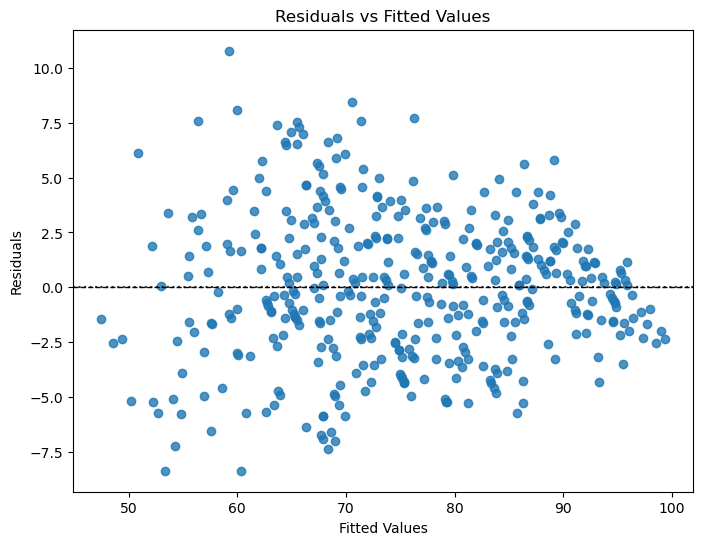

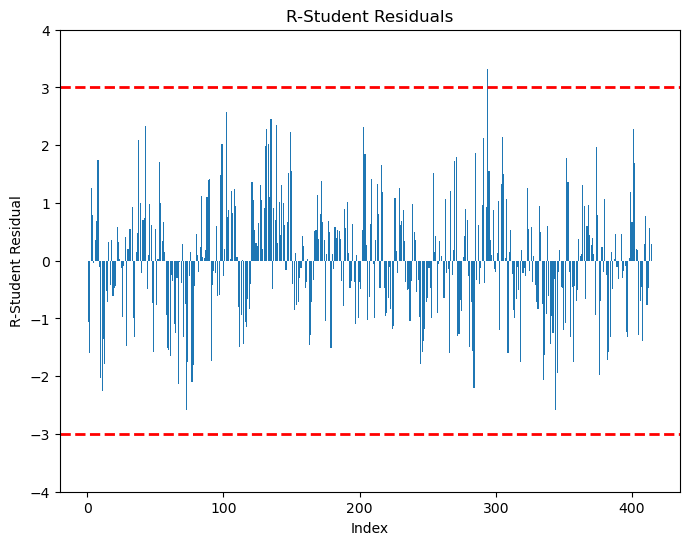

[293]


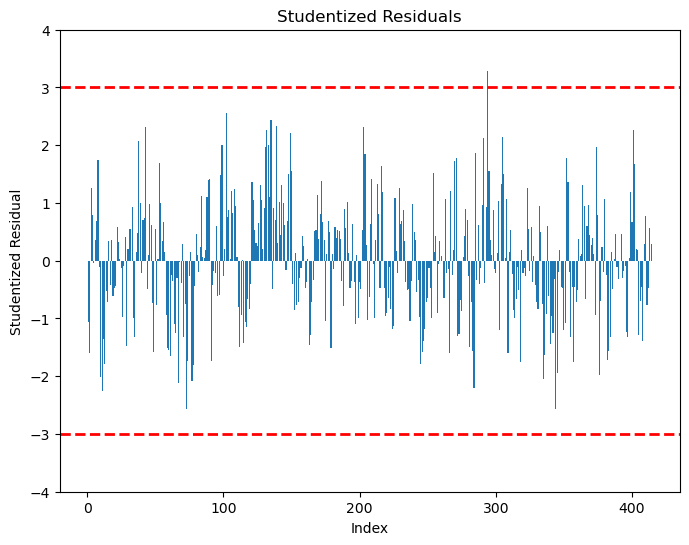

[293]


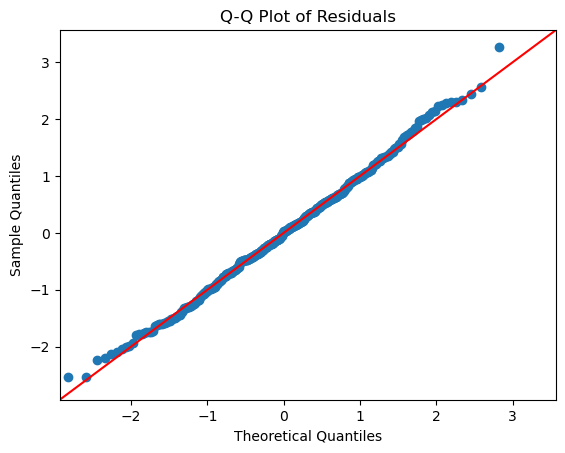

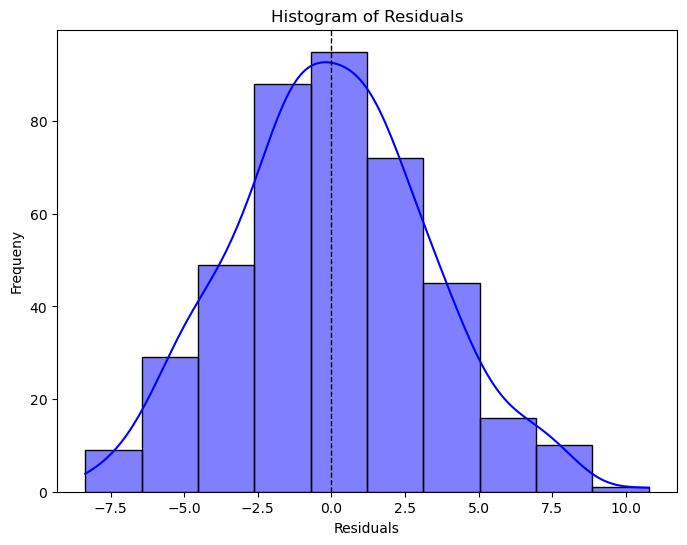

    Feature          VIF
0     const  1544.572438
1       GRE     4.515279
2     TOEFL     3.939989
3       SOP     2.693533
4       LOR     1.993461
5      CGPA     4.618952
6  Research     1.581576
Average Mean Squared Error (MSE): 11.566657802487702
Average Root Mean Squared Error (RMSE): 3.3892834659259394
Average R-squared (R²): 0.9207313848666768
     Actual  Predicted
0      92.0  95.512449
1      76.0  81.327567
5      90.0  89.017664
20     64.0  65.587742
25     94.0  95.847247
..      ...        ...
454    71.0  64.023920
464    45.0  49.556427
467    78.0  77.693504
481    78.0  73.715619
498    73.0  71.002658

[82 rows x 2 columns]
Shapiro-Wilk Test Statistic: 0.9967495778786182
Shapiro-Wilk Test P-Value: 0.5758887577031857
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'alpha': 0.5, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Test Set Metrics:
Mean Squar

C:\Users\Sarvesh\anaconda3\envs\GradPred\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [9]:
# Model w/ simple outlier removal (Linear Regression)
x_grad_df_mod = remove_outliers(x_grad_df_no_ur)
y_grad_df_mod = y_grad_df_no_ur[x_grad_df_mod.index]

resid = build_display_lm(x_grad_df_mod, y_grad_df_mod)
calculate_vifs(x_grad_df_mod)
test_model(x_grad_df_mod, y_grad_df_mod, 5)

# Model w/ filtered residuals (Linear Regression)
filtered_data = x_grad_df_mod[(resid >= -4.5) & (resid <= 14.5)]
filtered_target = y_grad_df_mod[(resid >= -4.5) & (resid <= 14.5)]

fil_resid = build_display_lm(filtered_data, filtered_target)
calculate_vifs(filtered_data)
test_model(filtered_data, filtered_target, 5)

# Shapiro-Wilk Test for Normality
stat, p_val = shapiro(fil_resid)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'Shapiro-Wilk Test P-Value: {p_val}')

# Model w/ filtered residuals (XGBoost)
xgb_mod_no_ur = run_XGBoost(param_grid, 5, filtered_data, filtered_target)

**<font size = 4> <font color = 'cyan'> MODEL BUILDING & TESTING (NO UNIV RTG & TRANSFORMATIONS) PT.3**

                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     642.6
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          4.48e-204
Time:                        13:00:17   Log-Likelihood:                 634.93
No. Observations:                 414   AIC:                            -1256.
Df Residuals:                     407   BIC:                            -1228.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8455      0.102     18.147      0.0

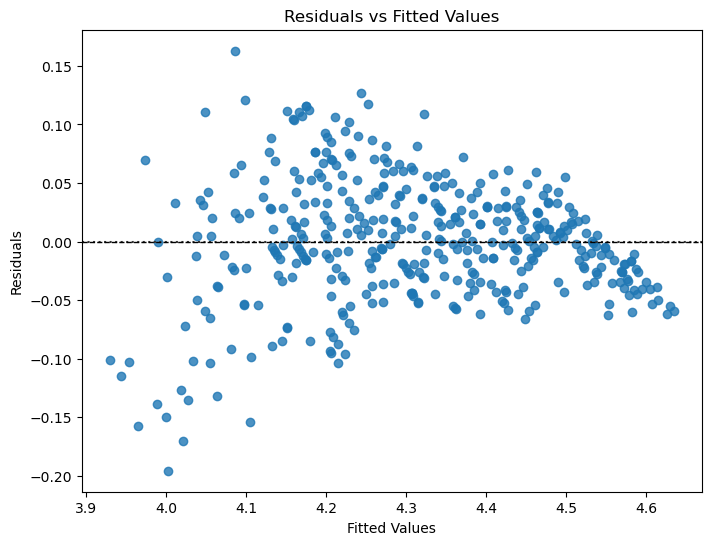

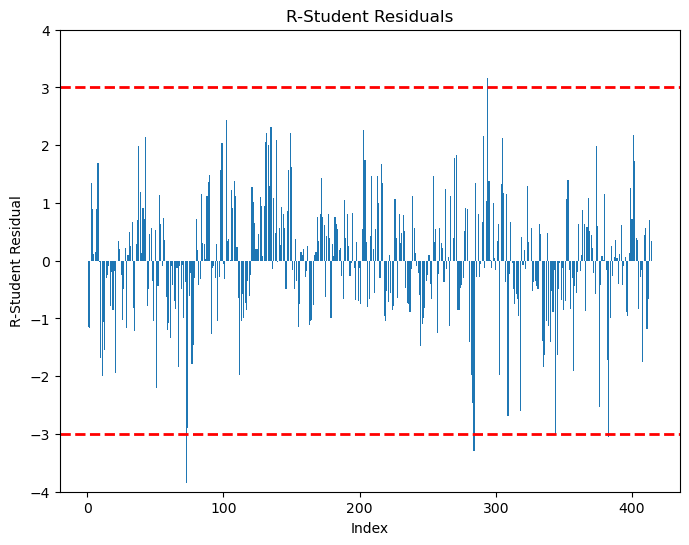

[ 72 283 293 382]


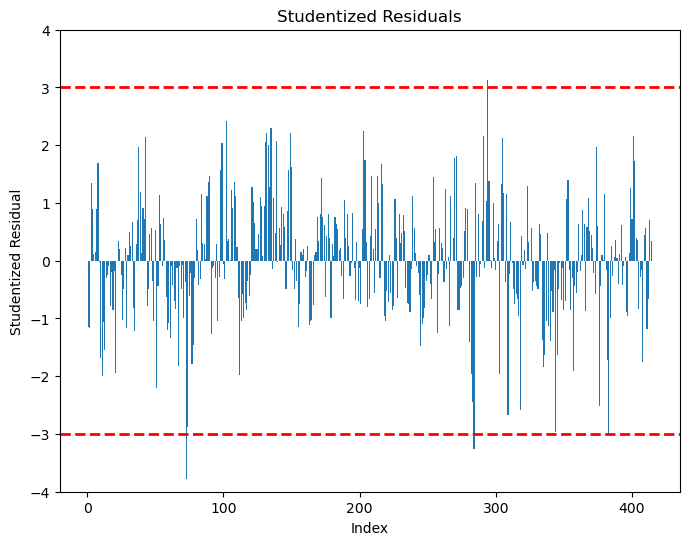

[ 72 283 293 382]


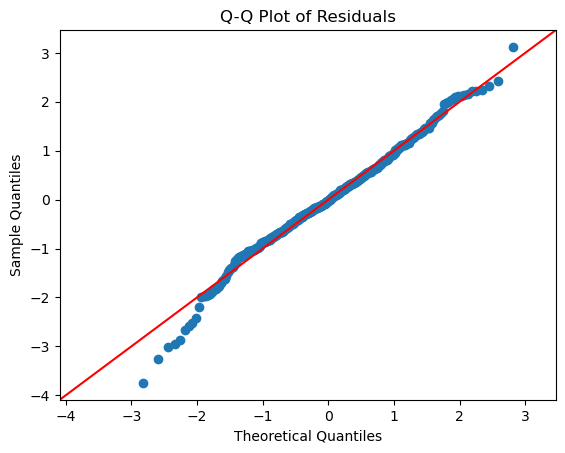

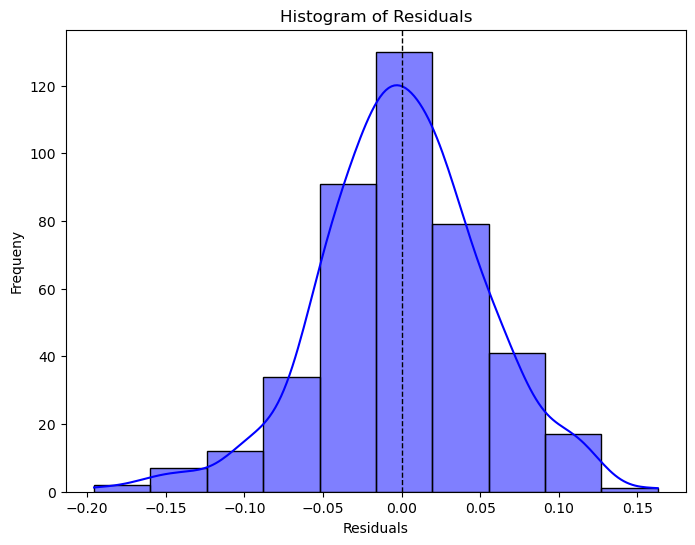

    Feature          VIF
0     const  1544.572438
1       GRE     4.515279
2     TOEFL     3.939989
3       SOP     2.693533
4       LOR     1.993461
5      CGPA     4.618952
6  Research     1.581576
Average Mean Squared Error (MSE): 0.002911862977903421
Average Root Mean Squared Error (RMSE): 0.05378432169277653
Average R-squared (R²): 0.8957631233449417
       Actual  Predicted
0    4.521789   4.582278
1    4.330733   4.392062
5    4.499810   4.494362
20   4.158883   4.172490
25   4.543295   4.585560
..        ...        ...
454  4.262680   4.151871
464  3.806662   3.954824
467  4.356709   4.344634
481  4.356709   4.284405
498  4.290459   4.251809

[82 rows x 2 columns]
Shapiro-Wilk Test Statistic: 0.9894083932893616
Shapiro-Wilk Test P-Value: 0.004346587379611075
                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:          

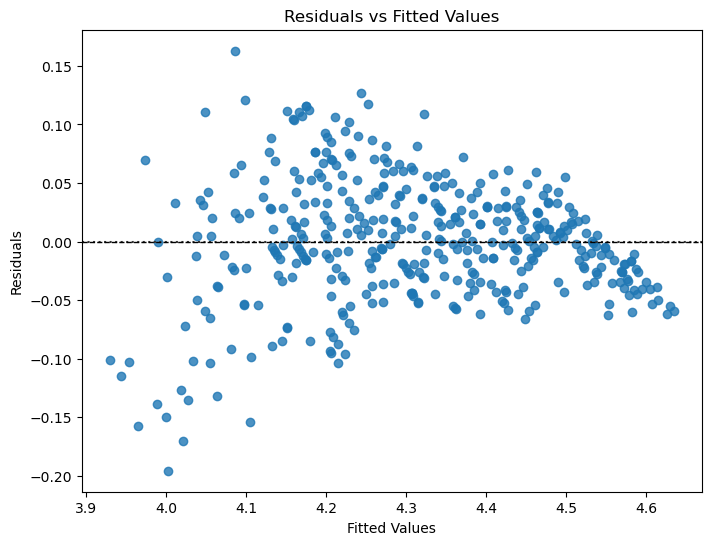

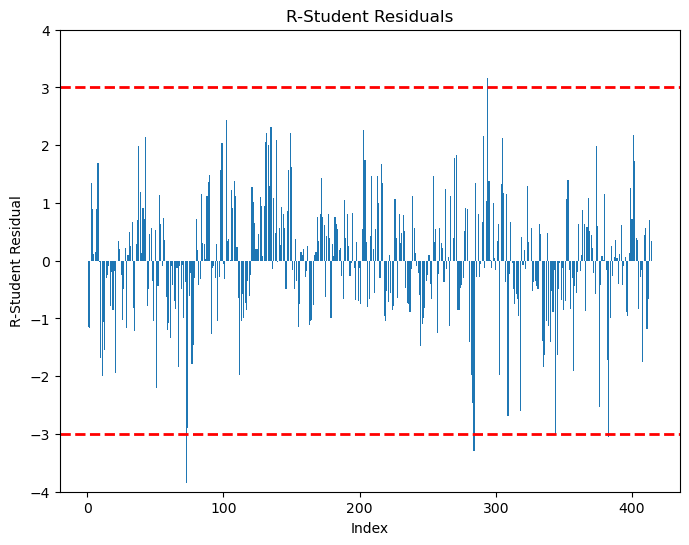

[ 72 283 293 382]


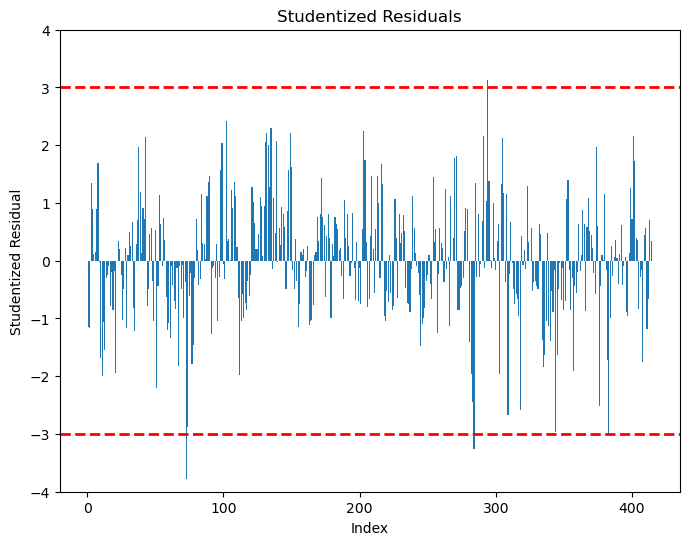

[ 72 283 293 382]


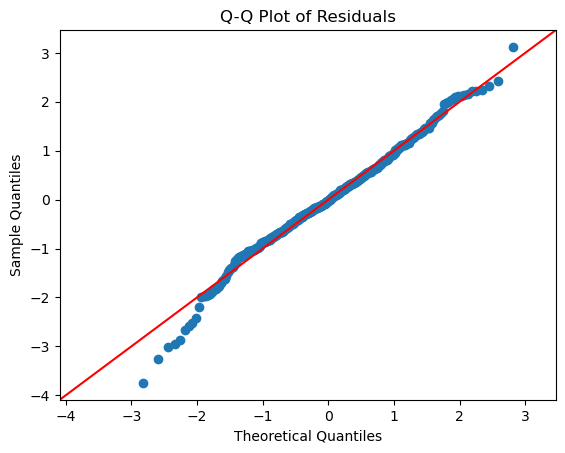

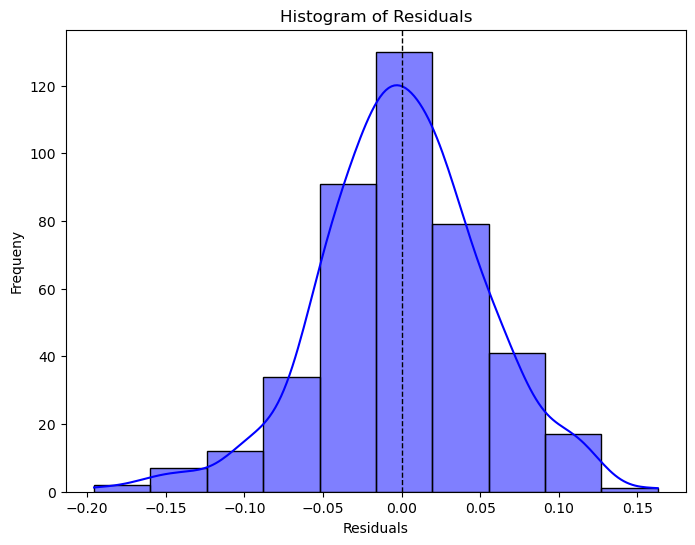

    Feature          VIF
0     const  1544.572438
1       GRE     4.515279
2     TOEFL     3.939989
3       SOP     2.693533
4       LOR     1.993461
5      CGPA     4.618952
6  Research     1.581576
Average Mean Squared Error (MSE): 0.002911862977903421
Average Root Mean Squared Error (RMSE): 0.05378432169277653
Average R-squared (R²): 0.8957631233449417
       Actual  Predicted
0    4.521789   4.582278
1    4.330733   4.392062
5    4.499810   4.494362
20   4.158883   4.172490
25   4.543295   4.585560
..        ...        ...
454  4.262680   4.151871
464  3.806662   3.954824
467  4.356709   4.344634
481  4.356709   4.284405
498  4.290459   4.251809

[82 rows x 2 columns]
Shapiro-Wilk Test Statistic: 0.9894083932893616
Shapiro-Wilk Test P-Value: 0.004346587379611075


In [10]:
# Possible Log Transformation
filtered_target_log = np.log(filtered_target)

fil_resid_log = build_display_lm(filtered_data, filtered_target_log)
calculate_vifs(filtered_data)
test_model(filtered_data, filtered_target_log, 5)

stat, p_val = shapiro(fil_resid_log)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'Shapiro-Wilk Test P-Value: {p_val}')

# Possible Square Root Transformation
filtered_target_sqrt = np.sqrt(filtered_target)

fil_resid_sqrt = build_display_lm(filtered_data, filtered_target_log)
calculate_vifs(filtered_data)
test_model(filtered_data, filtered_target_log, 5)

stat, p_val = shapiro(fil_resid_sqrt)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'Shapiro-Wilk Test P-Value: {p_val}')

**<font size = 4> <font color = 'cyan'> MODEL BUILDING & TESTING (ENCONDING DUMMY VARS) PT.4**

C:\Users\Sarvesh\AppData\Local\Temp\ipykernel_14244\486856390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_grad_df_ur['UnivRtg'] = pd.to_numeric(x_grad_df_ur['UnivRtg'], errors='coerce')


                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     324.4
Date:                Wed, 11 Dec 2024   Prob (F-statistic):          8.21e-180
Time:                        13:00:41   Log-Likelihood:                -1601.2
No. Observations:                 500   AIC:                             3218.
Df Residuals:                     492   BIC:                             3252.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -127.5725     10.430    -12.232      0.0

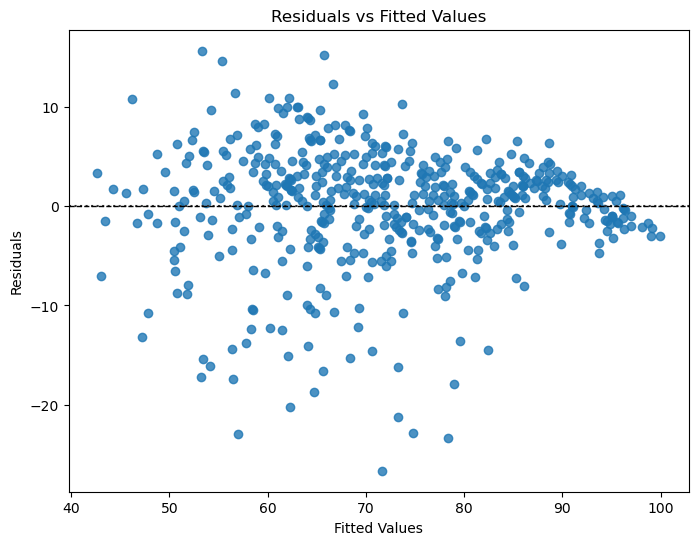

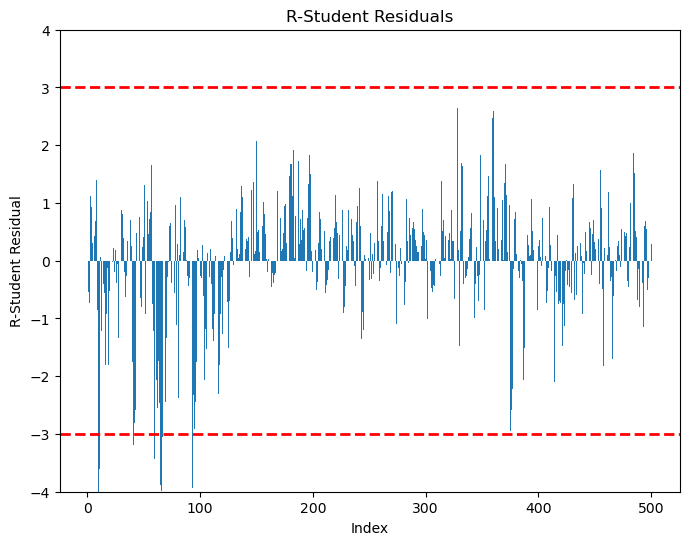

[ 9 10 40 59 64 65 66 92]


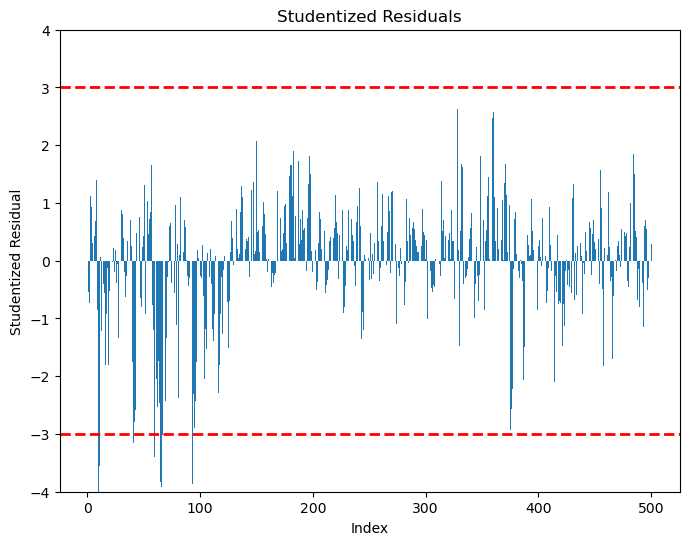

[ 9 10 40 59 64 65 66 92]


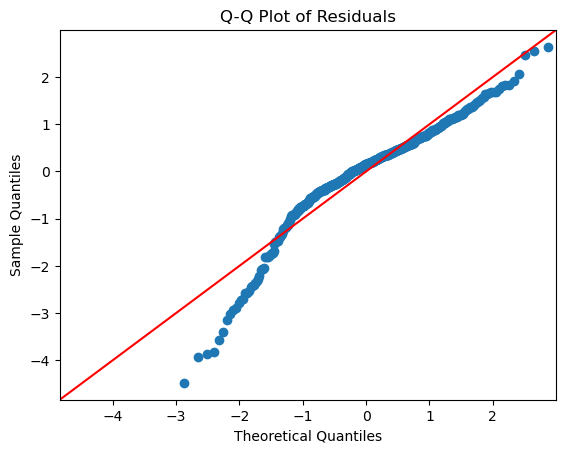

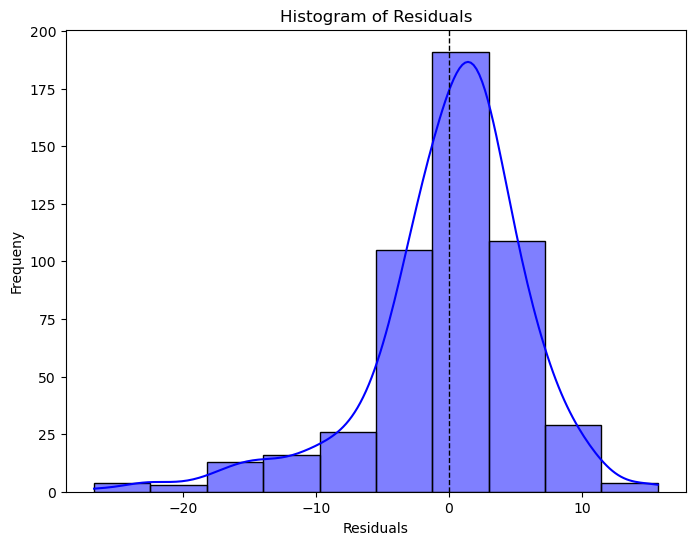

    Feature          VIF
0     const  1511.495830
1       GRE     4.464249
2     TOEFL     3.904213
3       SOP     2.835210
4       LOR     2.033555
5      CGPA     4.777992
6  Research     1.494008
7   UnivRtg     2.621036
Average Mean Squared Error (MSE): 36.56264243032385
Average Root Mean Squared Error (RMSE): 6.0174595189221876
Average R-squared (R²): 0.8155236077242559
     Actual  Predicted
0      92.0  95.148987
1      76.0  80.146647
5      90.0  87.385323
6      75.0  70.428993
11     84.0  83.366146
..      ...        ...
482    83.0  78.072164
488    76.0  76.649815
490    67.0  66.217731
494    68.0  64.203537
496    96.0  98.944346

[166 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:            AdmitChance   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     786.1
Date:

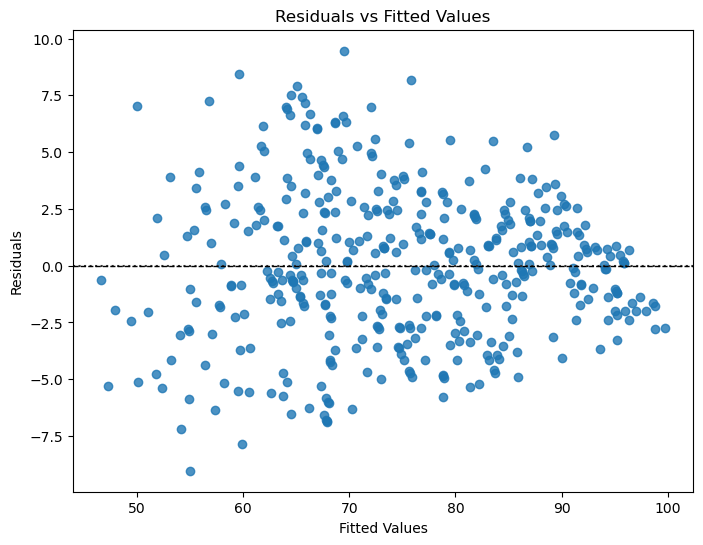

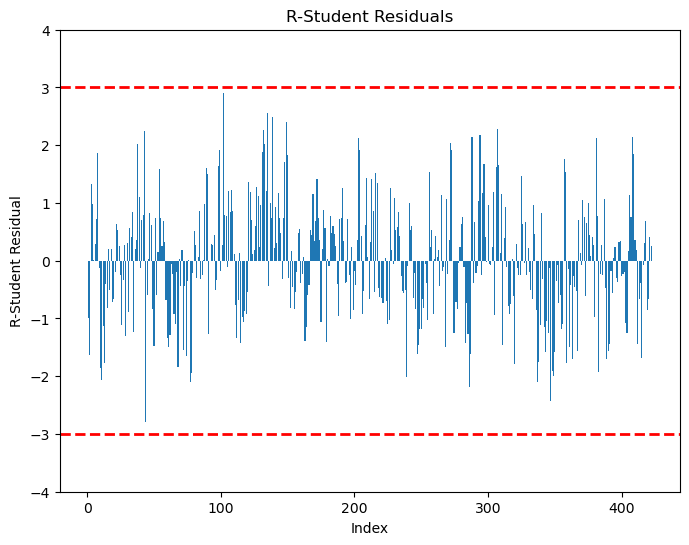

[]


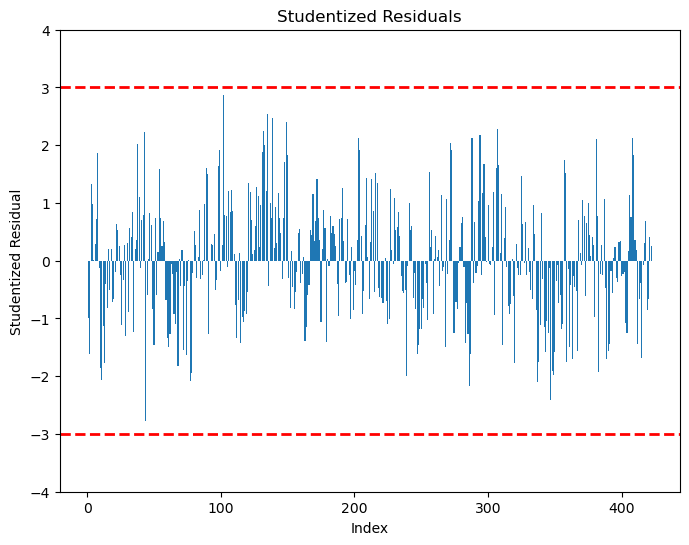

[]


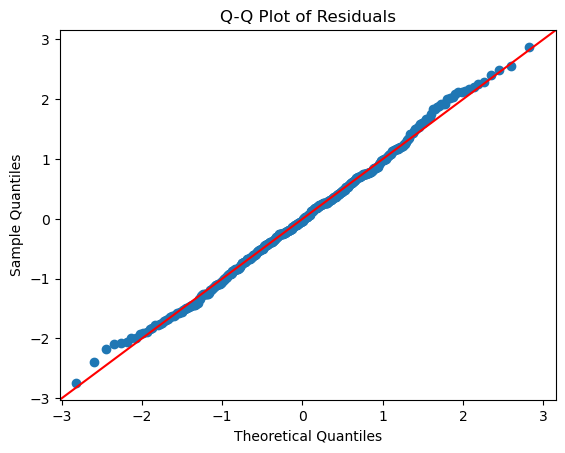

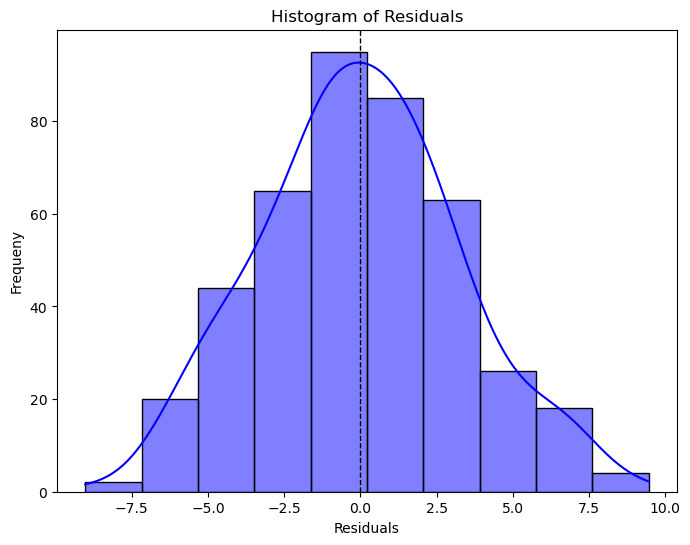

    Feature          VIF
0     const  1669.782132
1       GRE     4.616171
2     TOEFL     4.011676
3       SOP     3.212812
4       LOR     2.032472
5      CGPA     4.734057
6  Research     1.606039
7   UnivRtg     3.020534
Average Mean Squared Error (MSE): 11.290360753079403
Average Root Mean Squared Error (RMSE): 3.3543368234318804
Average R-squared (R²): 0.9263648520432297
     Actual  Predicted
0      92.0  95.148985
1      76.0  81.572634
5      90.0  89.257046
6      75.0  72.227136
17     65.0  68.800975
..      ...        ...
482    83.0  80.505554
488    76.0  77.866648
495    87.0  85.006358
497    93.0  95.043591
499    84.0  82.767104

[140 rows x 2 columns]
Shapiro-Wilk Test Statistic: 0.9962162891928372
Shapiro-Wilk Test P-Value: 0.416148323524531
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'alpha': 1, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Test 

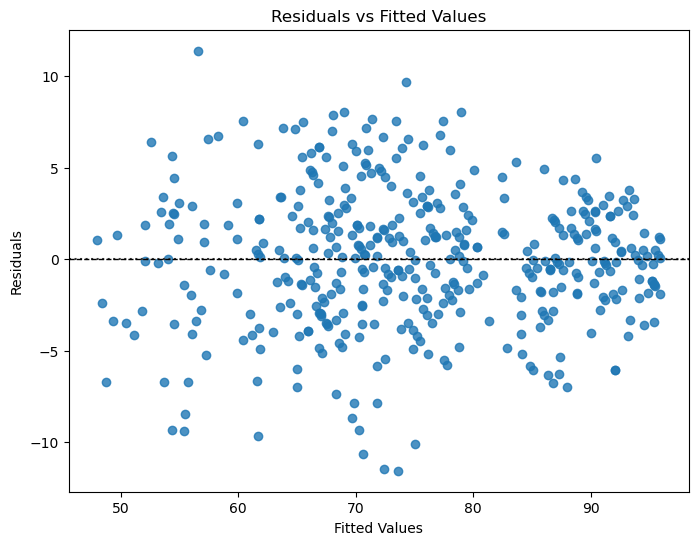

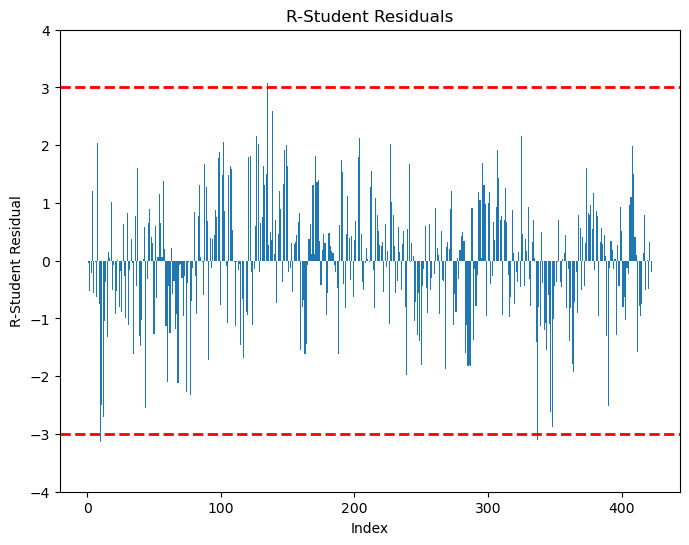

[  9 134 336]


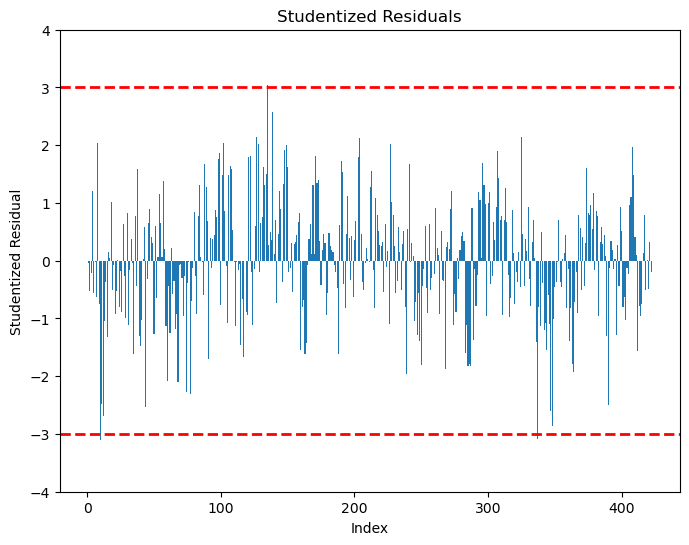

[  9 134 336]


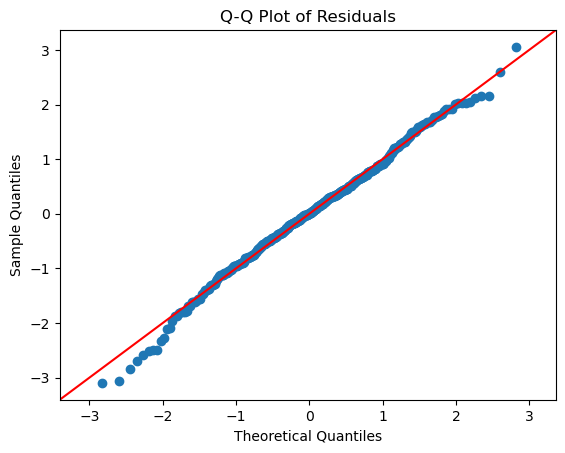

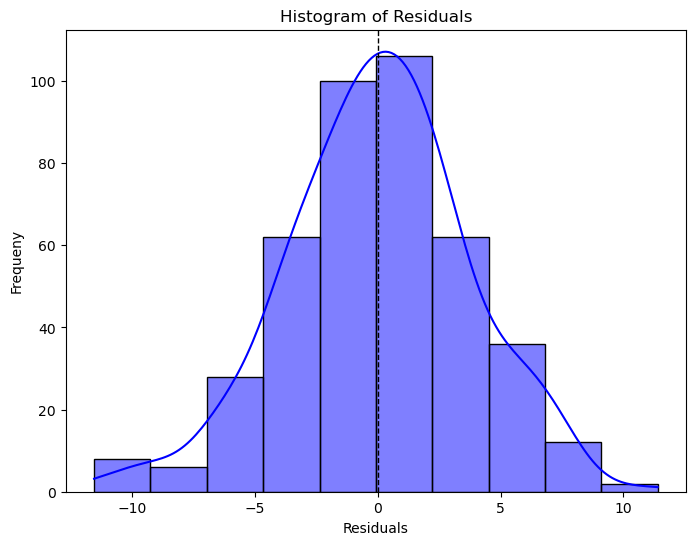

      Feature          VIF
0       const  1744.890391
1         GRE     4.298212
2       TOEFL     3.880667
3         SOP     3.019059
4         LOR     1.773816
5        CGPA     2.921926
6    Research     1.620117
7   UnivRtg_2     3.624898
8   UnivRtg_3     4.983112
9   UnivRtg_4     5.834229
10  UnivRtg_5     5.857449
Average Mean Squared Error (MSE): 14.733514518621526
Average Root Mean Squared Error (RMSE): 3.836044137737936
Average R-squared (R²): 0.904206985486195
     Actual  Predicted
0      92.0  91.938013
1      76.0  78.323769
5      90.0  90.352349
6      75.0  77.482086
17     65.0  75.944468
..      ...        ...
482    83.0  79.757362
488    76.0  78.978406
495    87.0  88.954924
497    93.0  94.487419
499    84.0  84.116562

[140 rows x 2 columns]
Shapiro-Wilk Test Statistic: 0.9949631639041768
Shapiro-Wilk Test P-Value: 0.18562302694627247
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'alpha': 0.5, 'colsample_bytree': 1.0, 'gamma'

In [11]:
# Build model w/ university rating and no dummy encoding
x_grad_df_ur = grad_df[['GRE', 'TOEFL', 'SOP', 'LOR', 'CGPA', 'Research', 'UnivRtg']]
y_grad_df_ur = grad_df['AdmitChance']
x_grad_df_ur['UnivRtg'] = pd.to_numeric(x_grad_df_ur['UnivRtg'], errors='coerce')
total_y = len(y_grad_df_ur)

ur_resid = build_display_lm(x_grad_df_ur, y_grad_df_ur)
calculate_vifs(x_grad_df_ur)
test_model(x_grad_df_ur, y_grad_df_ur, 3)

filtered_data_ur = x_grad_df_ur[(ur_resid >= -4.5) & (ur_resid <= 14.5)]
filtered_target_ur = y_grad_df_ur[(ur_resid >= -4.5) & (ur_resid <= 14.5)]

fil_resid = build_display_lm(filtered_data_ur, filtered_target_ur)
calculate_vifs(filtered_data_ur)
test_model(filtered_data_ur, filtered_target_ur, 3)

stat, p_val = shapiro(fil_resid)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'Shapiro-Wilk Test P-Value: {p_val}')

# XGBoost Model w/ university rating and no dummy encoding
xgb_ur_no_dum = run_XGBoost(param_grid, 5, filtered_data_ur, filtered_target_ur)

# Build model w/ university rating and dummy encoding

# Generate dummies for 'UnivRtg'
x_grad_df_ur_dum = pd.get_dummies(filtered_data_ur, columns=['UnivRtg'], drop_first=True)
x_grad_df_ur_dum = x_grad_df_ur_dum.astype(int)

dum_resid = build_display_lm(x_grad_df_ur_dum, filtered_target_ur)
calculate_vifs(x_grad_df_ur_dum)
test_model(x_grad_df_ur_dum, filtered_target_ur, 3)

# Shapiro-Wilk Test for Normality
stat, p_val = shapiro(dum_resid)
print(f'Shapiro-Wilk Test Statistic: {stat}')
print(f'Shapiro-Wilk Test P-Value: {p_val}')

# XGBoost Model w/ university rating and dummy encoding
xgb_ur = run_XGBoost(param_grid, 5, x_grad_df_ur_dum, filtered_target_ur)

**<font size = 4> <font color = 'cyan'> DISPLAY MODEL PERFORMANCES**

C:\Users\Sarvesh\AppData\Local\Temp\ipykernel_14244\201332238.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=model_df, palette='viridis')


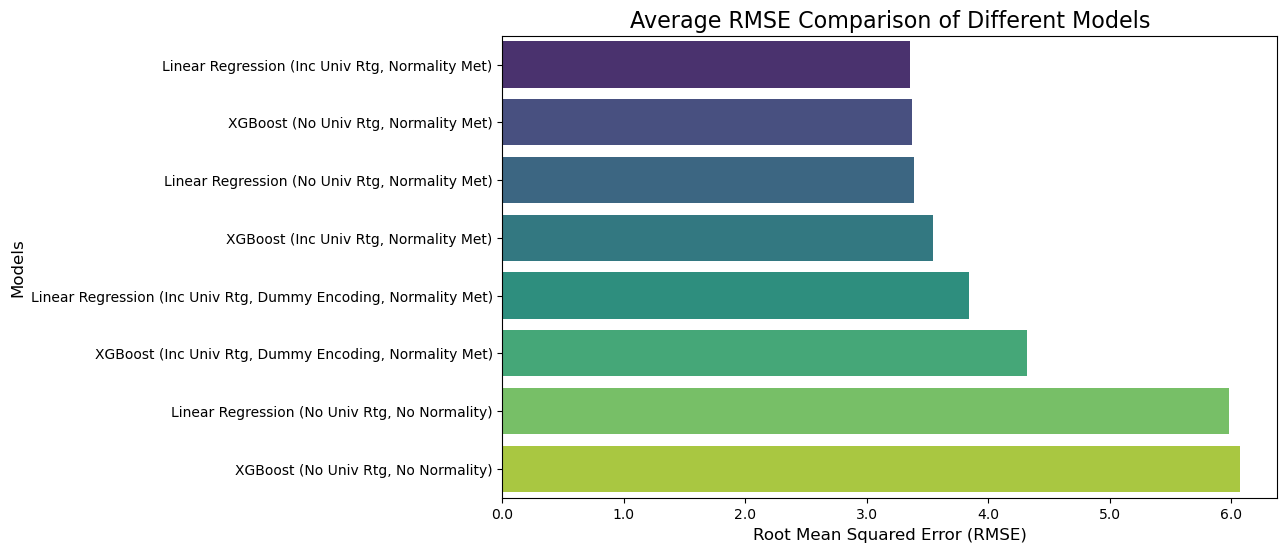

In [18]:
# ALL MODELS AND THEIR PERFORMANCES

# Linear Regression Models: 
# 1) No univ rtg, no linearity (RMSE: 5.98312702798502)
# 2) No univ rtg, linearity met (RMSE: 3.3892834659259394)
# 3) Inc univ rtg w/ no dummy encoding, linearity met (RMSE: 3.3543368234318804)
# 4) Inc univ rtg w/ dummy encoding, linearity met (RMSE: 3.836044137737936)

# XGBoost Models: 
# 1) No univ rtg, no linearity (RMSE: 6.074416563337169)
# 2) No univ rtg, linearity met (RMSE: 3.3730780708668706)
# 3) Inc univ rtg w/ no dummy enconding, linearity met (RMSE: 3.5437081003179087)
# 4) Inc univ rtg w/ dummy encoding, linearity met (RMSE: 4.313524224571041)

models = [
    "Linear Regression (No Univ Rtg, No Normality)",
    "Linear Regression (No Univ Rtg, Normality Met)",
    "Linear Regression (Inc Univ Rtg, Normality Met)",
    "Linear Regression (Inc Univ Rtg, Dummy Encoding, Normality Met)",
    "XGBoost (No Univ Rtg, No Normality)",
    "XGBoost (No Univ Rtg, Normality Met)",
    "XGBoost (Inc Univ Rtg, Normality Met)",
    "XGBoost (Inc Univ Rtg, Dummy Encoding, Normality Met)"
]

rmse_values = [
    5.98312702798502,  # Linear Regression (No Univ Rtg, No Linearity)
    3.3892834659259394,  # Linear Regression (No Univ Rtg, Linearity Met)
    3.3543368234318804,  # Linear Regression (Inc Univ Rtg, Linearity Met)
    3.836044137737936,  # Linear Regression (Inc Univ Rtg, Dummy Encoding)
    6.074416563337169,  # XGBoost (No Univ Rtg, No Linearity)
    3.3730780708668706,  # XGBoost (No Univ Rtg, Linearity Met)
    3.5437081003179087,  # XGBoost (Inc Univ Rtg, Linearity Met)
    4.313524224571041   # XGBoost (Inc Univ Rtg, Dummy Encoding)
]

model_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values
})

model_df = model_df.sort_values(by='RMSE', ascending=True)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=model_df, palette='viridis')

plt.xticks(ticks=range(0, int(model_df['RMSE'].max()) + 1), labels=[f'{x:.1f}' for x in range(0, int(model_df['RMSE'].max()) + 1)])

plt.title('Average RMSE Comparison of Different Models', fontsize=16)
plt.xlabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Show the plot
plt.show()

**<font size = 4> <font color = 'cyan'> SIMPLE FRONT END APP THROUGH STREAMLIT**

In [ ]:
%%writefile app.py
import pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
# from IPython.core.display import HTML

file_path = r'C:\Users\Sarvesh\Desktop\STAT 4355 Assignments\STAT 4355 Final Project\admission_data.csv'
grad_df = pd.read_csv(file_path)

# Assign column names
grad_df.columns = ['GRE', 'TOEFL', 'UnivRtg', 'SOP', 'LOR', 'CGPA', 'Research', 'AdmitChance']
# Remove duplicates
grad_df = grad_df.drop_duplicates()
# Remove entries with missing values
grad_df = grad_df.dropna()
# Check variable data types
# print(grad_df.info())

# Change scaling for AdmitChance
grad_df['AdmitChance'] = grad_df['AdmitChance'] * 100

x_grad_df_ur = grad_df[['GRE', 'TOEFL', 'SOP', 'LOR', 'CGPA', 'Research', 'UnivRtg']]
y_grad_df_ur = grad_df['AdmitChance']
x_grad_df_ur['UnivRtg'] = pd.to_numeric(x_grad_df_ur['UnivRtg'], errors='coerce')
total_y = len(y_grad_df_ur)

def build_display_lm(x_df, y_df):
    # Build and Display Model
    x_df = sm.add_constant(x_df)
    model_df = sm.OLS(y_df, x_df).fit()
    print(model_df.summary())

    total_y = len(y_df)

    # Calculate Residuals for Analysis
    residuals = model_df.resid
    R_stud_resid = model_df.get_influence().resid_studentized_external
    stud_resid = model_df.get_influence().resid_studentized_internal
    std_resid = residuals / np.std(residuals)
    fitted = model_df.fittedvalues

    # resid = {'org_resid': residuals, 'RStud_resid' : R_stud_resid, 
              #'Stud_resid' : stud_resid, 'Std_resid' : std_resid}
    
    # Build Residual Plot
    plt.figure(figsize = (8, 6))
    sns.residplot(x = fitted, y = residuals, line_kws = {'color' : 'red', 'lw' : 2})
    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 1)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

    # Build R-Student Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(R_stud_resid) + 1), R_stud_resid)
    plt.title('R-Student Residuals')
    plt.xlabel('Index')
    plt.ylabel('R-Student Residual')
    plt.ylim(-4, 4)
    
    plt.axhline(y=3, color='red', linewidth=2, linestyle='--')
    plt.axhline(y=-3, color='red', linewidth=2, linestyle='--')
    plt.show()
    
    R_stud_out = np.where((R_stud_resid >= 3) | (R_stud_resid <= -3))[0]
    print(R_stud_out)

    # Build Studentized Residuals Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(stud_resid) + 1), stud_resid)
    plt.title('Studentized Residuals')
    plt.xlabel('Index')
    plt.ylabel('Studentized Residual')
    plt.ylim(-4, 4)
    
    plt.axhline(y=3, color='red', linewidth=2, linestyle='--')
    plt.axhline(y=-3, color='red', linewidth=2, linestyle='--')
    plt.show()
    
    stud_out = np.where((stud_resid >= 3.0) | (stud_resid <= -3.0))[0]
    print(stud_out)

    # Build QQ-Plot
    sm.qqplot(residuals, line = '45', fit = True)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

    # Build Histogram of Residuals
    plt.figure(figsize = (8, 6))
    sns.histplot(residuals, kde = True, bins = math.ceil(math.log2(total_y) + 1), color = 'blue')
    plt.axvline(0, color = 'black', linestyle = '--', linewidth = 1)
    plt.xlabel('Residuals')
    plt.ylabel('Frequeny')
    plt.title('Histogram of Residuals')
    plt.show()

    return residuals

ur_resid = build_display_lm(x_grad_df_ur, y_grad_df_ur)

filtered_data_ur = x_grad_df_ur[(ur_resid >= -4.5) & (ur_resid <= 14.5)]
filtered_target_ur = y_grad_df_ur[(ur_resid >= -4.5) & (ur_resid <= 14.5)]

# Build the model that will be used for the app
app_model = sm.OLS(filtered_target_ur, sm.add_constant(filtered_data_ur)).fit()
print(app_model.summary())

# Save the model and its coefficients 
with open('admission_model.pkl', 'wb') as model_file:
   pickle.dump(app_model, model_file)

coefficients = app_model.params

with open('coefficients.pkl', 'wb') as coef_file:
    pickle.dump({'coefficients' : coefficients[1:], 'intercept' : coefficients['const']}, coef_file)

# Load the saved model
with open('admission_model.pkl', 'rb') as model_file:
    app_model = pickle.load(model_file)

# Load the model's coefficients
with open('coefficients.pkl', 'rb') as coef_file:
    app_model_data = pickle.load(coef_file)

st.set_page_config(
    page_title="Graduate Admission Predictor",
    page_icon="🎓",
    layout="centered",  # Or 'wide' for a wider layout
    initial_sidebar_state="expanded",  # Set 'collapsed' or 'expanded' for sidebar
)

# Custom CSS for dark mode
custom_css = """
<style>
/* General background and text styling */
[data-testid="stAppViewContainer"] {
    background-color: #121212; /* Black background */
    color: #FFA500; /* Orange text */
}

[data-testid="stSidebar"] {
    background-color: #121212; /* Black sidebar background */
    color: #FFA500; /* Orange text */
}

[data-testid="stSidebar"]::before {
    background-color: #121212;
}

/* Fix top bar white space */
[data-testid="stHeader"] {
    background-color: #121212; /* Match background */
    color: #FFA500; /* Orange text */
}

/* Remove gradient around slider numbers */
div[data-testid="stMarkdownContainer"] div {
    background: none !important; /* Remove gradient */
    border: none !important; /* Remove border */
    color: #FFA500 !important; /* Orange text */
}

/* Style slider */
.stSlider > div > div > div {
    background: linear-gradient(to right, #800080, #FFA500); /* Purple-to-orange gradient */
}

.stSlider > div > div > div > div {
    background-color: #FFA500; /* Orange handle */
}

/* Labels for sliders */
.stSlider label {
    color: #8B0000; /* Purple text */
}

/* Input fields and select box styling */
input[type="number"], input[type="text"], [data-baseweb="select"] {
    background-color: #1f1f1f; /* Dark input field background */
    color: #FFA500; /* Orange text */
    border: 1px solid #800080; /* Purple border */
}

/* Ensure CGPA input box has the same styling */
input[type="text"]#cgpa {
    background-color: #1f1f1f; /* Dark input field background */
    color: #FFA500; /* Orange text */
    border: 1px solid #800080; /* Purple border */
}

/* Handle focus effect for input fields */
input[type="text"]:focus, input[type="number"]:focus {
    border: 1px solid #FFA500 !important; /* Orange border on focus */
    outline: none !important; /* Remove default focus outline */
}

/* Dropdown menu styling */
[data-baseweb="menu"] {
    background-color: #1f1f1f !important; /* Dark dropdown background */
    color: #FFA500 !important; /* Orange text */
    border: 1px solid #800080; /* Purple border */
}

[data-baseweb="menu"] div:hover {
    background-color: #800080 !important; /* Purple hover */
    color: #121212 !important; /* Black text on hover */
}

/* Style sidebar hover color */
[data-testid="stSidebar"] a:hover {
    background-color: #800080; /* Purple background */
    color: #FFA500; /* Orange text */
}

/* Radio button styling */
div[data-testid="stRadio"] label {
    background-color: #1f1f1f !important; /* Dark radio background */
    color: #FFA500 !important; /* Orange text */
}

div[data-testid="stRadio"] label:hover {
    background-color: #800080 !important; /* Purple background on hover */
    color: #121212 !important; /* Black text */
}

/* Buttons */
button {
    background-color: #2e2e2e; /* Dark button background */
    color: #FFA500; /* Orange text */
    border: 1px solid #FFA500; /* Orange border */
}

button:hover {
    background-color: #FFA500; /* Orange hover */
    color: #121212; /* Black text */
}

/* Style text associated with input fields */
div[data-testid="stText"], span, p {
    color: #FFA500 !important; /* Orange text */
}

/* Style for select box */
div[data-baseweb="select"] > div {
    background-color: #1f1f1f !important; /* Dark background for the select box */
    color: #FFA500 !important; /* Orange text */
}

/* Prevent gradient from affecting the select label and text */
div[data-baseweb="select"] > div > div {
    background: none !important; /* Remove gradient background */
}

/* Ensure the select option text color stays orange */
div[data-baseweb="select"] > div > div > div {
    color: #FFA500 !important; /* Orange text */
}
</style>
"""

# Inject custom CSS into the Streamlit app
st.markdown(custom_css, unsafe_allow_html=True)

coefficients = app_model_data['coefficients']
intercept = app_model_data['intercept']

# Calculate the Percentiles for the Recommendations
percentiles = {
    'GRE' : np.percentile(filtered_data_ur['GRE'], 50),
    'TOEFL' : np.percentile(filtered_data_ur['TOEFL'], 50), 
    'SOP' : np.percentile(filtered_data_ur['SOP'], 50), 
    'LOR' : np.percentile(filtered_data_ur['LOR'], 50), 
    'CGPA' : np.percentile(filtered_data_ur['CGPA'], 50), 
    'UnivRtg' : np.percentile(filtered_data_ur['UnivRtg'], 50)
}

# Title of the App
st.title("Graduate Admission Predictor")
st.write("""Welcome to the Graduate Admission Predictor. Enter your
         academic profile to predict your graduate admission chance
         and to receive personalized academic recommendations.""")


# User Input
st.header("Enter Your Academic Profile")
gre = st.slider("GRE Score (260 - 340)", min_value = 260, max_value = 340, step = 1)
toefl = st.slider("TOEFL Score (0 - 120)", min_value = 0, max_value = 120, step = 1)
sop = st.selectbox("SOP Strength (0-5)", options = [0, 0.5, 1, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5])
lor = st.selectbox("LOR Strength (0-5)", options = [0, 0.5, 1, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5])
cgpa = st.number_input("CGPA (0-10, ex. 8.57)", min_value = 0.0, max_value = 10.0, step = 0.01)
research = st.radio("Research Experience", options = ["No", "Yes"])
univ_rtg = st.selectbox("University Rating (0-5)", options = [0, 1, 2, 3, 4, 5])

st.sidebar.write("**Your Inputs:**")
st.sidebar.write(f"GRE: {gre}")
st.sidebar.write(f"TOEFL: {toefl}")
st.sidebar.write(f"SOP: {sop}")
st.sidebar.write(f"LOR: {lor}")
st.sidebar.write(f"CGPA: {cgpa}")
st.sidebar.write(f"Research: {research}")
st.sidebar.write(f"University Rating: {univ_rtg}")

research_binary = 1 if research == "Yes" else 0

user_data = {
    "GRE" : gre, 
    "TOEFL" : toefl, 
    "SOP" : sop, 
    "LOR" : lor, 
    "CGPA" : cgpa, 
    "Research" : research_binary, 
    "UnivRtg" : univ_rtg
}

user_df = pd.DataFrame([user_data])

# Predict admission chance
def predict_admission(features, coefficients, intercept):
    prediction = intercept

    for feature in coefficients.index:
        feature_value = features[feature].values[0]
        feature_coefficient = coefficients[feature]
        cont = feature_value * feature_coefficient
        prediction += cont

    if (prediction <= 0):
        return 0.0
    elif (prediction >= 100):
        return 100.0
    else: 
        return prediction

st.markdown("### Prediction Result")

prediction = predict_admission(user_df, coefficients, intercept)
st.write(f"Predicted Chance of Admission: **{prediction:.2f}%**")

st.markdown("### Model Diagnostics")

# Interactive Scatter Plot (Actual vs Predicted Admission Chances)
import plotly.express as px
import pandas as pd

# Assuming actual_y and pred_y are already defined
# Replace this with your actual code for actual_y and pred_y
actual_y = filtered_target_ur
pred_y = app_model.predict(sm.add_constant(filtered_data_ur))

# Create DataFrame for the scatter plot
df = pd.DataFrame({'Actual': actual_y, 'Predicted': pred_y})

# Create the scatter plot
fig = px.scatter(df, 
                 x='Predicted', 
                 y='Actual', 
                 title='Actual vs Predicted Admission Chances',
                 labels={'Predicted': 'Predicted Admission Chances', 'Actual': 'Actual Admission Chances'})

# Update trace to set marker color to orange and customize the markers
fig.update_traces(marker=dict(size=10, opacity=0.5, line=dict(width=1, color='black'), color='#FFA500'))

# Update layout to set background colors to purple and text colors to orange
fig.update_layout(
    plot_bgcolor='#121212',  # Purple background for the plot area
    paper_bgcolor='#121212',  # Purple background for the entire figure
    title='Actual vs Predicted Admission Chances',
    title_x = 0,  # Center title
    title_font=dict(color='#FFA500'),  # Orange title color
    xaxis=dict(title='Predicted Admission Chances', title_font=dict(color='#FFA500')),
    yaxis=dict(title='Actual Admission Chances', title_font=dict(color='#FFA500'))
)

st.plotly_chart(fig)


# Interactive Feature Plot
fig = px.bar(x=coefficients.index, 
             y=coefficients.values, 
             labels={'x': 'Feature', 'y': 'Coefficient'}, 
             title='Feature Impact on Prediction')

# Update layout to set background color to purple and text color to orange
fig.update_layout(
    plot_bgcolor='#121212',  # Purple background for the plot area
    paper_bgcolor='#121212',  # Purple background for the entire figure
    title='Feature Impact on Prediction',
    title_x= 0,  # Center title
    title_font=dict(color='#FFA500'),  # Orange title color
    xaxis=dict(title='Feature', title_font=dict(color='#FFA500'), tickfont=dict(color='#FFA500')),
    yaxis=dict(title='Coefficient', title_font=dict(color='#FFA500'), tickfont=dict(color='#FFA500'))
)

# Update traces to set bar color to orange and make the edges black
fig.update_traces(marker=dict(color='#FFA500', line=dict(width=1, color='black')))

# Show the plot in Streamlit
st.plotly_chart(fig)